# Links

Slideshow:
https://docs.google.com/presentation/d/1oIJ3wWmAQvcdvw89Q68oa8f4kc3APT_V1DrUOXsBDp4/edit?usp=sharing

Video:
https://youtu.be/cZ1j1EuVD9I

README:
https://drive.google.com/file/d/1yRf8_HTG3J0HDHogmGXd7D4LZAfWkXZ_/view?usp=drive_link

Original Dataset:
https://docs.google.com/spreadsheets/d/1MHVhRyJ1CyU0-QrfAJrgTm2Ipja9_Ak2/edit?usp=sharing&ouid=106661652649559871823&rtpof=true&sd=true

Nearest Features CSV:
https://drive.google.com/file/d/16shn9poafgW24lZxkbuWJAEeCv4DHMOO/view?usp=sharing

Climate Population Density CSV:
https://drive.google.com/file/d/1Y32GPcfjyicRzlb04DqHA75E5r3qixhB/view?usp=sharing



# Features we will use:
Common Features between models:
- 'lotSize'
- 'livingArea'
- 'hasGarage'
- 'hasAttachedProperty'
- 'hasView',
- 'hasHOA'
- 'AnnualHOAFee'
- 'fullBathrooms'
- 'halfBathrooms'
- 'bedrooms'
- 'homeType'
- 'propertyTaxRate'
- 'yearBuilt',
- 'hasHomeWarranty'

Features in old model:
- 'latitude'
- 'longitude'

New Features in the new model:
- 'motorway' (nearest highway in meters)
- 'park' (nearest park in meters)
- 'supermarket' (nearest grocery store in meters)
- 'Costco' (nearest Costco in meters)
- 'population_density' (person per sq ft)
- 'elevation' (in feet)
- 'mean_daily_high_temperature'(in Fahrenheit)
- 'mean_daily_low_temperature' (in Fahrenheit)
- 'rainfall' (average rainfall in inches)

In [1789]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, mean_squared_error
from sklearn.metrics.pairwise import haversine_distances
import xgboost as xgb
import seaborn as sns
import requests
from bs4 import BeautifulSoup
import typing
from typing import List, Tuple
from math import radians, sin, cos, sqrt, atan2
import json
import time
import re
from urllib.parse import quote
from tqdm.notebook import tqdm
# !pip install shap
import shap
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from io import StringIO
import os

Notebook Setup

In [1790]:
# palette = sns.color_palette("Purples_d")
# style = "white"
# context = "talk"
# custom_params = {"axes.spines.right": False, "axes.spines.top": False}
# sns.set_theme(context=context, style=style, palette=palette, rc=custom_params)
# sns.despine()

In [1791]:
# Define the custom palette
coffee_cream_palette = ["#4B3D3D", "#F3E1D3", "#D6CFC4", "#A8BFA2", "#C5B29D"]
coffee_cream_cmap = ListedColormap(coffee_cream_palette)
style = "white"
context = "talk"
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(context=context, style=style, palette=coffee_cream_palette, rc=custom_params)
sns.despine()

<Figure size 640x480 with 0 Axes>

In [1792]:
# !mkdir figures
figure_path = "./figures/"

In [1793]:
# from google.colab import files

# EDA

In [1794]:
data = pd.read_excel("./lotwize_case.xlsx")

In [1795]:
data.shape

(9142, 356)

In [1796]:
display(data)

,schools/0/distance,schools/1/grades,schools/2/level,schools/0/name,schools/1/rating,schools/2/size,schools/0/totalCount,schools/1/type,county,isRentalListingOffMarket,...,nearbyHomes/1/propertyTypeDimension,nearbyHomes/1/state,nearbyHomes/2/bathrooms,nearbyHomes/2/bedrooms,nearbyHomes/2/livingArea,nearbyHomes/2/livingAreaUnits,nearbyHomes/2/livingAreaUnitsShort,nearbyHomes/2/livingAreaValue,nearbyHomes/2/zpid,resoFacts/flooring/0
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Condo,CA,2.0,2.0,1555.0,Square Feet,sqft,1555.0,111718685.0,Tile
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tile
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hardwood
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9137,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Single Family,CA,1.0,2.0,1036.0,Square Feet,sqft,1036.0,24980514.0,Hardwood Flrs Throughout
9138,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Multi Family,CA,2.0,2.0,1061.0,Square Feet,sqft,1061.0,79529691.0,Carpet
9139,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Townhouse,CA,1.5,2.0,1056.0,Square Feet,sqft,1056.0,25048817.0,Laminate
9140,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Check NA Values

In [1797]:
data.isna().sum()

schools/0/distance                    6734
schools/1/grades                      7145
schools/2/level                       7566
schools/0/name                        6734
schools/1/rating                      7523
                                      ... 
nearbyHomes/2/livingAreaUnits         4698
nearbyHomes/2/livingAreaUnitsShort    4370
nearbyHomes/2/livingAreaValue         4370
nearbyHomes/2/zpid                    4081
resoFacts/flooring/0                  5024
Length: 356, dtype: int64

In [1798]:
data.columns[data.isna().sum()<1000]

Index(['address/city', 'address/streetAddress', 'address/zipcode',
       'attributionInfo/lastUpdated', 'bathrooms', 'bedrooms', 'city',
       'currency', 'dateSoldString', 'formattedChip/location/0/fullValue',
       'formattedChip/location/1/fullValue', 'hasBadGeocode', 'homeStatus',
       'homeType', 'isCurrentSignedInAgentResponsible',
       'isCurrentSignedInUserVerifiedOwner',
       'isListingClaimedByCurrentSignedInUser', 'latitude',
       'listingDataSource', 'livingArea', 'livingAreaUnitsShort',
       'livingAreaValue', 'longitude', 'lotAreaUnits', 'maloneId',
       'mortgageZHLRates/thirtyYearFixedBucket/lastUpdated',
       'mortgageZHLRates/thirtyYearFixedBucket/rateSource', 'price',
       'rentZestimate', 'resoFacts/atAGlanceFacts/0/factLabel',
       'resoFacts/atAGlanceFacts/0/factValue',
       'resoFacts/atAGlanceFacts/1/factLabel',
       'resoFacts/atAGlanceFacts/1/factValue',
       'resoFacts/atAGlanceFacts/2/factLabel',
       'resoFacts/atAGlanceFacts/3/

## Explore HOA Data

In [1799]:
HOA = data.loc[:, ["resoFacts/hasAssociation", "monthlyHoaFee", "resoFacts/atAGlanceFacts/5/factLabel", "resoFacts/atAGlanceFacts/5/factValue", "resoFacts/feesAndDues/0/type"]]
print(HOA.dtypes)
HOA

resoFacts/hasAssociation                float64
monthlyHoaFee                           float64
resoFacts/atAGlanceFacts/5/factLabel     object
resoFacts/atAGlanceFacts/5/factValue     object
resoFacts/feesAndDues/0/type             object
dtype: object


,resoFacts/hasAssociation,monthlyHoaFee,resoFacts/atAGlanceFacts/5/factLabel,resoFacts/atAGlanceFacts/5/factValue,resoFacts/feesAndDues/0/type
0,0.0,632.0,HOA,$632 monthly,NaN
1,0.0,NaN,Lot,"2,501 sqft",HOA
2,0.0,NaN,Lot,"4,991 sqft",NaN
3,1.0,158.0,HOA,$158 monthly,HOA
4,1.0,362.0,HOA,$362 monthly,NaN
...,...,...,...,...,...
9137,0.0,NaN,Lot,"4,791 sqft",NaN
9138,1.0,790.0,HOA,$790 monthly,NaN
9139,1.0,250.0,HOA,$250 monthly,NaN
9140,0.0,NaN,Lot,"7,113 sqft",HOA


In [1800]:
# checking if data points that have conflicting data for HOA variables
HOA.loc[(HOA["monthlyHoaFee"] == pd.NA) & (HOA["resoFacts/atAGlanceFacts/5/factValue"].str.startswith("$"))]

,resoFacts/hasAssociation,monthlyHoaFee,resoFacts/atAGlanceFacts/5/factLabel,resoFacts/atAGlanceFacts/5/factValue,resoFacts/feesAndDues/0/type


the features ```resoFacts/hasAssociation``` and ```resoFacts/feesAndDues/0/type``` are unreliable so we construct our own feature based off if ```resoFacts/atAGlanceFacts/5/factValue``` has a dollar value. If it does, then we know this is a fee for the HOA.

## Explore Space Data

In [1801]:
space = data.loc[:, ["livingArea", "livingAreaUnitsShort", "lotSize", "lotAreaUnits", "lotAreaValue"]]
space

,livingArea,livingAreaUnitsShort,lotSize,lotAreaUnits,lotAreaValue
0,1413.0,sqft,5767.0,Square Feet,5767.344000
1,1892.0,sqft,2501.0,Square Feet,2501.000000
2,4169.0,sqft,4991.0,Square Feet,4991.976000
3,3549.0,sqft,13200.0,Acres,0.303030
4,1440.0,sqft,1433.0,Square Feet,1433.000000
...,...,...,...,...,...
9137,1164.0,sqft,4791.0,Square Feet,4791.600000
9138,1106.0,sqft,NaN,sqft,NaN
9139,1056.0,sqft,960.0,Square Feet,960.000000
9140,2362.0,sqft,7113.0,Square Feet,7113.000000


```lotSize``` is just ```lotAreaValue``` converted into sqft units

no feature engineering needed, just use ```livingArea``` and ```lotSize```

## Explore Layout Data

In [1802]:
layout = data.loc[:, ["resoFacts/storiesTotal", "resoFacts/bathroomsFull", "resoFacts/bathroomsHalf", "bathrooms", "resoFacts/levels"]]
print(layout["resoFacts/levels"].unique())
layout

[nan 'Two' 'Multi/Split' 'One' 'Three Or More' 'Single Story' 'Two Story'
 'Three or More Stories' 'One Story' '3 Story' 'Three Or More,Multi/Split'
 'Two Story,Two' 'Entry Lvl(No Stairs),Single Story' 'Two,Multi/Split'
 'Multi/Split,Two' 'One,Two' 'Multi/Split,One' 'One,Single Level'
 'Two,Three Or More' 'Two,One' '4 Story' 'Single Story,Two'
 'Entry Lvl(No Stairs)' 'Tri-Level,Two' 'Single Story,Outside Stairs'
 'Outside Stairs' 'Split Level' 'Four,Lower' 'Multi/Split,Three Or More'
 'Five or More,Two' 'One Story,One' 'Tri-Level'
 'Three or More Stories,Three Or More' 'Other' 'Tri-Level,Three Or More'
 'Other/Remarks' 'One,Three Or More' 'Single Story,Two,Outside Stairs'
 'Two Story,One' 2 1 3 'Split Level,One' 'One,Multi/Split'
 'Split Level,Two' 'Three or More Stories,One'
 'Two Story,One,Two,Three Or More' 'Two,Outside Stairs' 'Other,One']


,resoFacts/storiesTotal,resoFacts/bathroomsFull,resoFacts/bathroomsHalf,bathrooms,resoFacts/levels
0,NaN,2.0,1.0,3.0,NaN
1,2.0,2.0,1.0,3.0,Two
2,NaN,4.0,0.0,4.0,Multi/Split
3,2.0,2.0,1.0,3.0,Two
4,2.0,2.0,1.0,3.0,Two
...,...,...,...,...,...
9137,NaN,1.0,0.0,1.0,One Story
9138,NaN,2.0,NaN,2.0,NaN
9139,NaN,1.0,1.0,2.0,NaN
9140,2.0,3.0,NaN,3.0,Two


The types of ```resoFacts/levels``` are undecipherable so we will just exclude it from our dataset.

We will only rename column names for bathrooms.

## Explore Amentities Data

In [1803]:
amenities = data.loc[:, ["resoFacts/fireplaces", "resoFacts/hasFireplace", "resoFacts/hasGarage", "resoFacts/garageParkingCapacity", "resoFacts/hasAttachedGarage", "resoFacts/atAGlanceFacts/4/factValue", "resoFacts/parkingCapacity", "resoFacts/parkingFeatures/0", "resoFacts/hasAttachedProperty", "resoFacts/hasView"]]
amenities

,resoFacts/fireplaces,resoFacts/hasFireplace,resoFacts/hasGarage,resoFacts/garageParkingCapacity,resoFacts/hasAttachedGarage,resoFacts/atAGlanceFacts/4/factValue,resoFacts/parkingCapacity,resoFacts/parkingFeatures/0,resoFacts/hasAttachedProperty,resoFacts/hasView
0,1.0,1.0,True,0.0,NaN,2 Garage spaces,2.0,Assigned,False,False
1,NaN,1.0,True,2.0,1.0,2 Attached Garage spaces,2.0,Direct Access,False,True
2,NaN,1.0,True,3.0,0.0,3 Garage spaces,5.0,Garage - 2 Car,False,True
3,NaN,1.0,True,3.0,1.0,3 Attached Garage spaces,3.0,Garage - Attached,False,True
4,NaN,1.0,True,2.0,1.0,2 Attached Garage spaces,2.0,Garage - Attached,True,True
...,...,...,...,...,...,...,...,...,...,...
9137,1.0,1.0,True,1.0,1.0,1 Attached Garage space,1.0,Attached,False,False
9138,NaN,NaN,True,1.0,NaN,1 Garage space,1.0,Assigned,False,False
9139,1.0,NaN,True,1.0,NaN,1 Garage space,2.0,Carport,False,True
9140,NaN,1.0,True,3.0,1.0,3 Attached Garage spaces,3.0,Garage - Attached,False,True


In [1804]:
print(amenities["resoFacts/fireplaces"].unique())

[ 1. nan  3.  2.  0.  4.  5.]


In [1805]:
print(amenities["resoFacts/garageParkingCapacity"].unique())

[  0.    2.    3.    nan   1.    6.    4.    5.    2.5   7.   10.    9.
   8.   16.  517.  400. ]


In [1806]:
print(amenities["resoFacts/atAGlanceFacts/4/factValue"].unique())

['2 Garage spaces' '2 Attached Garage spaces' '3 Garage spaces'
 '3 Attached Garage spaces' '1 Attached Garage space' '6 Garage spaces'
 '2 Open Parking spaces' '1 Parking space' 'Garage' '4 Garage spaces'
 'On Street' '3 Parking spaces' '3 Covered Parking spaces' '0 spaces'
 '1 Garage space' 'Off-street' '5 Open Parking spaces' '2 Carport spaces'
 '8 Open Parking spaces' '4 Carport spaces' 'No Data'
 '6 Attached Garage spaces' '5 Covered Parking spaces' '4 Parking spaces'
 '2 Parking spaces' 'Garage - Detached' '3 Open Parking spaces'
 '3 Carport spaces' '5 Garage spaces' '1 Carport space' '8 Carport spaces'
 'Open Parking' 'Garage - Attached' nan '4 Attached Garage spaces'
 'Attached Garage' 'On Street, Parking Area' '2 Covered Parking spaces'
 '1 Open Parking space' 'No Garage' 'Garage - Attached, Garage - Detached'
 '5 Carport spaces' '5 Attached Garage spaces' '4 Open Parking spaces'
 '6 Parking spaces' '7 Parking spaces' 'Garage - Detached, Off-street'
 'Carport' '7 Garage spaces

In [1807]:
print(amenities["resoFacts/parkingCapacity"].unique())

[  2.    5.    3.    4.    6.   12.    1.    0.    9.    8.    7.   13.
   4.5  11.    2.5  42.   17.   25.   -2.  -15.   10.   -4.   15.   16.
 125.   14.   20.  237.  517.  400.   30. ]


In [1808]:
print(amenities["resoFacts/parkingFeatures/0"].unique())

['Assigned' 'Direct Access' 'Garage - 2 Car' 'Garage - Attached'
 'Garage Door Opener' 'Garage: Attached' 'Garage' 'Attached' 'Driveway'
 'Carport' 'RV Possible' 'Covered' 'Built-In Storage' 'On Street' nan
 'RV Access/Parking' 'Detached' 'Off-street'
 'Electric Vehicle Charging Station(s)' 'Garage Is Detached' 'Open'
 'Parking Area' 'Garage: None Known' 'Controlled Entrance'
 'Garage Faces Front' 'Side By Side' 'Garage: Direct Garage Access'
 'Garage - Detached' 'Garage Faces Rear' 'Detached Carport' 'Enclosed'
 'Garage - Two Door' 'Auto Driveway Gate' 'Unassigned' 'Driveway Level'
 'No Garage' 'Circular Driveway' 'Garage - Single Door' 'Boat'
 'Off Street' 'Driveway - Combination' 'Garage: Detached' 'Paved'
 'Above Street Level' 'Guest' 'Garage: Garage' 'Private Garage'
 'Garage - 1 Car' 'Storage' 'Driveway Up Slope From Street'
 'Attached Carport' 'Garage Is Attached' 'Paver Block' 'Converted Garage'
 'Other' 'Concrete' 'Garage - 4+ Car' 'Air Conditioned Garage' 'Gated'
 'Community 

There is quite a lot of variation when it comes to parking, so we will just not use it for now.

In [1809]:
bool_cols = ["resoFacts/hasFireplace", "resoFacts/hasGarage", "resoFacts/hasAttachedGarage", "resoFacts/hasAttachedProperty", "resoFacts/hasView"]
cat_cols = ["resoFacts/fireplaces", "resoFacts/garageParkingCapacity", "resoFacts/atAGlanceFacts/4/factValue", "resoFacts/parkingCapacity", "resoFacts/parkingFeatures/0"]
amenities[bool_cols] = amenities[bool_cols].astype("boolean")
amenities[cat_cols] = amenities[cat_cols].astype("category")

print(amenities["resoFacts/hasAttachedGarage"].isna().value_counts())
print(amenities["resoFacts/hasGarage"].isna().value_counts())
print(amenities["resoFacts/hasFireplace"].isna().value_counts())
print(amenities["resoFacts/hasAttachedProperty"].isna().value_counts())
print(amenities["resoFacts/hasView"].isna().value_counts())

resoFacts/hasAttachedGarage
False    5717
True     3425
Name: count, dtype: int64
resoFacts/hasGarage
False    9142
Name: count, dtype: int64
resoFacts/hasFireplace
False    6781
True     2361
Name: count, dtype: int64
resoFacts/hasAttachedProperty
False    9142
Name: count, dtype: int64
resoFacts/hasView
False    9142
Name: count, dtype: int64


We will only use ```resoFacts/hasAttachedProperty```, ```resoFacts/hasView```, and ```resoFacts/hasGarage``` for our dataset because the other ones have too many null values

## Explore Misc Data

In [1810]:
data["dateSoldString"].dt.year.astype("category").value_counts(dropna=False)

dateSoldString
 2024.0    9141
NaN           1
Name: count, dtype: int64

In [1811]:
data["homeStatus"].value_counts(dropna=False)

homeStatus
RECENTLY_SOLD    8760
NaN               378
FORECLOSED          3
FOR_SALE            1
Name: count, dtype: int64

In [1812]:
data["homeType"].value_counts(dropna=False)

homeType
SINGLE_FAMILY        6172
CONDO                1436
TOWNHOUSE             483
NaN                   378
MULTI_FAMILY          327
MANUFACTURED          202
LOT                    61
HOME_TYPE_UNKNOWN      52
APARTMENT              31
Name: count, dtype: int64

# Data Cleaning

## Create data cleaning functions

These functions transform features into the correct types, rename long column names, creates new augmented features, and fills some columns null values with assumed values

In [1813]:
def HOADataProducer(df):
    HOA = df.loc[:, ["resoFacts/hasAssociation", "monthlyHoaFee", "resoFacts/atAGlanceFacts/5/factLabel", "resoFacts/atAGlanceFacts/5/factValue"]]
    HOA["hasHOA"] = HOA["resoFacts/atAGlanceFacts/5/factValue"].str.startswith("$", na=False)
    HOA[["HOAFee", "HOAFeeFrequency"]] = HOA["resoFacts/atAGlanceFacts/5/factValue"].where(HOA["hasHOA"]).str.extract(r'^\$(\d+)\s(\D+)')
    HOA["HOAFee"] = HOA["HOAFee"].astype("float64")
    HOA['AnnualHOAFee'] = HOA.apply(
        lambda row: row['HOAFee'] * 12 if row['hasHOA'] and row['HOAFeeFrequency'] == 'monthly' else (row['HOAFee'] if row['hasHOA'] else 0),
        axis=1
    )
    HOA["hasHOA"] = HOA["hasHOA"].astype("boolean")
    df = pd.concat([df, HOA[["hasHOA", "AnnualHOAFee"]]], axis=1)
    return df

In [1814]:
def LayoutDataProducer(df):
    df = df.rename(columns={"resoFacts/bathroomsFull": "fullBathrooms", "resoFacts/bathroomsHalf": "halfBathrooms"})
    df["fullBathrooms"] = df["fullBathrooms"].fillna(0)
    df["halfBathrooms"] = df["halfBathrooms"].fillna(0)
    df["bedrooms"] = df["bedrooms"].fillna(0)
    df["fullBathrooms"] = df["fullBathrooms"].astype("Int64")
    df["halfBathrooms"] = df["halfBathrooms"].astype("Int64")
    df["bedrooms"] = df["bedrooms"].astype("Int64")
    return df

In [1815]:
def AmenitiesDataProducer(df):
    df = df.rename(columns={"resoFacts/hasAttachedProperty": "hasAttachedProperty", "resoFacts/hasView": "hasView", "resoFacts/hasGarage":"hasGarage"})
    bool_cols = ["hasGarage", "hasAttachedProperty", "hasView"]
    df[bool_cols] = df[bool_cols].astype("boolean")
    return df

In [1816]:
def MiscDataProducer(df):
    df.drop("city", axis=1, inplace=True) # we will replace city with a different city column
    df = df.rename(columns={"resoFacts/hasHomeWarranty": "hasHomeWarranty", "address/city": "city"})
    df.loc[df["city"].str.contains("bear valley", case=False), "city"] = "Tehachapi" # Apparently the city "Bear Valley" is another word for the city "Tehachiapi"
    df["city"] = df["city"].str.lower()
    df['city'] = df['city'].replace('', pd.NA)
    df["city"] = df["city"].astype("category")
    df["homeType"] = df['homeType'].replace(pd.NA, "HOME_TYPE_UNKNOWN")
    df["yearBuilt"] = df["yearBuilt"].astype("Int64")
    df["hasHomeWarranty"] = df["hasHomeWarranty"].astype("boolean")
    df["homeType"] = df["homeType"].astype("category")
    return df

In [1817]:
data = HOADataProducer(data)
data = LayoutDataProducer(data)
data = AmenitiesDataProducer(data)
data = MiscDataProducer(data)

In [1818]:
data.loc[:, ["latitude", "longitude"]].isna().value_counts()

latitude  longitude
False     False        8756
True      False         377
          True            9
Name: count, dtype: int64

In [1819]:
data['latitude'] = data['latitude'].fillna(
    data['nearbyHomes/0/latitude']).fillna(
    data['nearbyHomes/1/latitude']).fillna(
    data['nearbyHomes/3/latitude'])

In [1820]:
data['longitude'] = data['longitude'].fillna(
    data['nearbyHomes/0/longitude']).fillna(
    data['nearbyHomes/1/longitude']).fillna(
    data['nearbyHomes/3/longitude'])

In [1821]:
data.loc[:, ["latitude", "longitude"]].isna().value_counts()

latitude  longitude
False     False        9141
True      True            1
Name: count, dtype: int64

In [1822]:
data.dropna(subset=["latitude", "longitude"], inplace=True)

In [1823]:
data.shape

(9141, 357)

## Feature Engineering

### Climate Webscraping

Temperatures are in fahrenheit

In [1824]:
# Get unique cities from your dataset
unique_cities = data['city'].unique()

# Print the unique cities
print(unique_cities)

['san francisco', 'redondo beach', 'los angeles', 'orange', 'newport beach', ..., 'del rey oaks', 'colma', 'torrance', 'roseville', 'east garrison']
Length: 102
Categories (102, object): ['anaheim', 'aptos', 'bakersfield', 'bonny doon', ..., 'west hollywood', 'woodland hills', 'woodside', 'yorba linda']


In [1825]:
# Helper function to extract numeric values from a string
def extract_numeric_value(value_str):
    """
    Extracts numeric values from a string, handling commas, negative signs, and various formats.
    Returns None if no valid number is found.
    """
    if value_str:
        # Use regular expression to find the numeric part, including decimals and negative numbers
        match = re.findall(r"[-+]?\d*\.\d+|\d+", value_str.replace(',', '').replace('−', '-'))
        if match:
            return float(match[0])
    return None

In [1826]:
def get_california_city_wiki_url(city_name):
    def is_california_city_page(url):
        try:
            response = requests.get(url, timeout=5)
            if response.status_code != 200:
                return False

            # Check if redirected to disambiguation
            if 'disambiguation' in response.url:
                return False

            soup = BeautifulSoup(response.content, 'html.parser')

            # Get the main content div
            content = soup.find('div', {'id': 'mw-content-text'})
            if not content:
                return False

            # Find first paragraph after content div
            # This skips the infobox and finds the actual first text paragraph
            first_p = None
            for p in soup.find_all('p'):
                # Skip if paragraph is inside a table
                if not p.find_parent('table'):
                    if p.text.strip():  # Check if paragraph has text
                        first_p = p
                        break

            # Check if page mentions its a city
            if first_p:
                text = first_p.text.lower()

                city_indicators = [
                    'city', 'town', 'municipality', 'metropolitan',
                    'county', 'population', 'census-designated place',
                    'incorporated', 'unincorporated', 'neighborhood'
                ]

                # Check for city indicators
                if not any(indicator in text for indicator in city_indicators):
                    return False

                # Check for geographic coordinates
                has_coords = bool(soup.find('span', class_='geo'))

                # Check infobox
                infobox = soup.find('table', class_=['infobox', 'geography', 'vcard'])
                if infobox:
                    infobox_text = infobox.text.lower()
                    has_city_info = any(x in infobox_text for x in [
                        'population', 'density', 'elevation', 'coordinates',
                        'mayor', 'timezone'
                    ])

                    if has_city_info:
                        return True
            return False

        except Exception as e:
            print(f"Error checking URL {url}: {str(e)}")
            return False

    try:
        # Clean city name
        clean_city = city_name.strip()
        if clean_city.lower().endswith(', california'):
            clean_city = clean_city[:-11].strip()
        elif clean_city.lower().endswith(' ca'):
            clean_city = clean_city[:-3].strip()
        clean_city = clean_city.title()
        variants = [
            f"{clean_city.replace(' ', '_')},_California",  # City,_California
            clean_city.replace(' ', '_'),  # Just city name
            f"{clean_city.replace(' ', '_')}_city",  # City_city
            f"{clean_city.replace(' ', '_')}_(California)",  # City_(California)
            f"{clean_city.replace(' ', '_')},_CA"  # City,_CA
            f"{clean_city.replace(' ', '_')},_Los_Angeles"  # City,_CA
        ]

        # Try each variant
        for variant in variants:
            url = f'https://en.wikipedia.org/wiki/{variant}'
            if is_california_city_page(url):
                return url

        return None

    except Exception as e:
        print(f"Error processing {city_name}: {str(e)}")
        return None

In [1827]:
# Function to scrape climate data (average temperature, rainfall, elevation, population density) for a given city
def get_city_climate_data(city_name):
    # Format city name for URL
    url = get_california_city_wiki_url(city_name)

    time.sleep(1)

    # Send request to Wikipedia
    response = requests.get(url)
    response.raise_for_status()
    soup = BeautifulSoup(response.content, 'html.parser')

    # Initialize dictionary to store climate and population data
    climate_data = {
        'city': city_name,
        'elevation': None,
        'rainfall': None,
        'mean_daily_high_temperature': None,
        'mean_daily_low_temperature': None,
        'population_density': None,
        'latitude': None,
        'longitude': None
    }

    # Scrape Elevation and Population Density (usually in the infobox on the right-hand side)
    infobox = soup.find('table', {'class': 'infobox'})
    if infobox:
        for row in infobox.find_all('tr'):
            if 'Elevation' in row.text:
                elevation_data = row.find_next('td').text.strip()
                climate_data['elevation'] = extract_numeric_value(elevation_data)

            # Scrape population density if available
            if 'Population density' in row.text or 'Density' in row.text:
                pop_density_data = row.find_next('td').text.strip()
                climate_data['population_density'] = extract_numeric_value(pop_density_data)

            # Scrape Coordinate Values of Cities
            if 'Coordinates' in row.text:
                # Extract the coordinates
                coord_link = row.find('span', {'class': 'geo'})
                if coord_link:
                    coords = coord_link.text.split('; ')
                    latitude = float(coords[0])
                    longitude = float(coords[1])
                    climate_data['latitude'] = latitude
                    climate_data['longitude'] = longitude

    # Scrape Temperature and Rainfall from climate table
    climate_table = None
    tables = soup.find_all('table', class_='wikitable')

    for table in tables:
        if 'climate' in str(table).lower() or 'weather' in str(table).lower():
            climate_table = table
            break

    if climate_table:
        df = pd.read_html(StringIO(str(climate_table)))[0]

        # If there's a multi-index in columns, flatten it
        # Basically ignore multi-index column
        if isinstance(df.columns, pd.MultiIndex):
            # Join multi-level column names with underscore
            df.columns = [f"{col[1]}" if pd.notna(col[1]) else col[0]
                         for col in df.columns]

            # Remove any double underscores and strip whitespace
            df.columns = [col.replace('__', '_').strip()
                         for col in df.columns]

        # Helper function to locate mean value for the year for a specified row in climate dataframe
        def tableFinder(df: pd.DataFrame, text_search: str) -> pd.Series:
            return df.loc[df["Month"].str.contains(text_search, case=False), "Year"]

        # Helper function to convert Series of strings into dict of floats for temperatures
        def cleanTableValues(series: pd.Series) -> List[float]:
            if not series.empty:
                values = series.values[0].split()
                values[1] = re.sub(r'()', '', values[0]) # remove parenthesis from Celcius value
                values = list(map(float, values))
                return values
            else:
                return [None, None]

        mean_daily_max = tableFinder(df, "mean daily max")
        mean_daily_max = cleanTableValues(mean_daily_max)
        mean_daily_max = {"C": mean_daily_max[0], "F": mean_daily_max[1]}
        climate_data["mean_daily_high_temperature"] = mean_daily_max.get("F")

        mean_daily_min = tableFinder(df, "mean daily min")
        mean_daily_min = cleanTableValues(mean_daily_min)
        mean_daily_min = {"C": mean_daily_min[0], "F": mean_daily_min[1]}
        climate_data["mean_daily_low_temperature"] = mean_daily_min.get("F")

        mean_precipiation = tableFinder(df, "Average precipitation inches")
        mean_precipiation = cleanTableValues(mean_precipiation)
        mean_precipiation = {"mm": mean_precipiation[0], "inches": mean_precipiation[1]}
        climate_data["rainfall"] = mean_precipiation.get("inches")

    return climate_data

In [1828]:
def haversine_distance(lat1, lon1, lat2, lon2):
  """
  Calculate the haversine distance between two coordinate points
  """
  R = 6371  # Earth radius in kilometers

  lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
  dlat = lat2 - lat1
  dlon = lon2 - lon1

  a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
  c = 2 * atan2(sqrt(a), sqrt(1-a))
  return R * c * 1000  # Convert to meters

In [1829]:
def find_nearest_city(target_city: dict, city_list: List[dict]) -> dict:
    """
    Takes a target city information as a dict containing coordinates and a list of dicts of cities and their coordinates and returns the nearest city info as dict
    """
    target_lat = target_city["latitude"]
    target_lon = target_city["longitude"]

    nearest_city = None
    shortest_distance = float('inf')

    for city in city_list:
        city_lat = city["latitude"]
        city_lon = city["longitude"]
        distance = haversine_distance(target_lat, target_lon, city_lat, city_lon)

        if distance < shortest_distance:
            shortest_distance = distance
            nearest_city = city

    return nearest_city, shortest_distance

In [1830]:
def impute_climate_and_elevation(df: pd.DataFrame):
    missing_climate = df[df["mean_daily_high_temperature"].isna() |
                     df["mean_daily_low_temperature"].isna() |
                     df["rainfall"].isna()]

    has_climate = df.drop(missing_climate.index)
    has_climate_list = has_climate.to_dict("records")

    for index, missing_climate_row in missing_climate.iterrows():
        nearest_city_dict, distance = find_nearest_city(missing_climate_row.to_dict(), has_climate_list)
        missing_climate.loc[index, "mean_daily_high_temperature"] = nearest_city_dict["mean_daily_high_temperature"]
        missing_climate.loc[index, "mean_daily_low_temperature"] = nearest_city_dict["mean_daily_low_temperature"]
        missing_climate.loc[index, "rainfall"] = nearest_city_dict["rainfall"]
        missing_climate.loc[index, "elevation"] = nearest_city_dict["elevation"]
        print(f"distance from {missing_climate_row['city']} to {nearest_city_dict['city']} is {distance/1000:.2f} kilometers away")

    return pd.concat([missing_climate, has_climate]).sort_index()

**WARNING**: If this is your first time running the code and don't have the extra dataset 'climate_population_density.csv' provided, then uncomment the code below to get the csv. Otherwise, you can keep the code commented out for faster runtime.


In [1831]:
# all_climate_data = []

# # Iterate through the list of unique cities and get climate data for each
# for city in unique_cities:
#     # print(f"Scraping climate data for {city}...")
#     city_climate_data = get_city_climate_data(city)

#     if city_climate_data:
#         all_climate_data.append(city_climate_data)

# climate_df = pd.DataFrame(all_climate_data)

# # Save the merged dataset if needed
# climate_df.to_csv("climate_population_density.csv", index=False)
# files.download("climate_population_density.csv")

In [1832]:
climate_df = pd.read_csv("climate_population_density.csv")

In [1833]:
climate_df.columns

Index(['city', 'elevation', 'rainfall', 'mean_daily_high_temperature',
       'mean_daily_low_temperature', 'population_density', 'latitude',
       'longitude'],
      dtype='object')

In [1834]:
print(climate_df.loc[:, "mean_daily_high_temperature"].isna().value_counts())
print(climate_df.loc[:, "mean_daily_low_temperature"].isna().value_counts())
print(climate_df.loc[:, "rainfall"].isna().value_counts())
print(climate_df.loc[:, "elevation"].isna().value_counts())
print(climate_df.loc[:, "population_density"].isna().value_counts())

mean_daily_high_temperature
False    72
True     30
Name: count, dtype: int64
mean_daily_low_temperature
False    72
True     30
Name: count, dtype: int64
rainfall
False    66
True     36
Name: count, dtype: int64
elevation
False    98
True      4
Name: count, dtype: int64
population_density
False    91
True     11
Name: count, dtype: int64


In [1835]:
display(climate_df)

,city,elevation,rainfall,mean_daily_high_temperature,mean_daily_low_temperature,population_density,latitude,longitude
0,san francisco,52.0,22.89,64.1,51.3,18634.65,37.77750,-122.41639
1,redondo beach,62.0,13.76,70.6,54.4,12000.00,33.85806,-118.37889
2,los angeles,233.0,NaN,74.8,56.8,8205.00,34.05000,-118.25000
3,orange,190.0,13.84,76.0,52.0,5452.49,33.80306,-117.83250
4,newport beach,10.0,9.43,68.2,57.3,1600.00,33.61667,-117.89750
...,...,...,...,...,...,...,...,...
97,del rey oaks,82.0,NaN,NaN,NaN,1510.44,36.59333,-121.83500
98,colma,121.0,NaN,NaN,NaN,796.93,37.67889,-122.45556
99,torrance,89.0,13.64,71.9,54.1,7200.00,33.83472,-118.34139
100,roseville,164.0,20.45,74.0,50.0,3210.20,38.75250,-121.28944


In [1836]:
imputed_climate_df = impute_climate_and_elevation(climate_df)

distance from los angeles to glendale is 10.70 kilometers away
distance from rancho palos verdes to torrance is 8.75 kilometers away
distance from ventura to oxnard is 10.19 kilometers away
distance from anaheim to fullerton is 6.06 kilometers away
distance from garden grove to seal beach is 11.51 kilometers away
distance from west hills to canoga park is 2.94 kilometers away
distance from aptos to capitola is 4.23 kilometers away
distance from lakewood to seal beach is 10.42 kilometers away
distance from brea to fullerton is 6.05 kilometers away
distance from morgan hill to gilroy is 14.75 kilometers away
distance from soquel to capitola is 1.43 kilometers away
distance from daly city to south san francisco is 6.07 kilometers away
distance from laguna niguel to newport beach is 20.37 kilometers away
distance from placentia to yorba linda is 3.94 kilometers away
distance from cupertino to santa clara is 6.56 kilometers away
distance from los alamitos to seal beach is 5.07 kilometers aw

In [1837]:
print(imputed_climate_df.loc[:, "mean_daily_high_temperature"].isna().value_counts())
print(imputed_climate_df.loc[:, "mean_daily_low_temperature"].isna().value_counts())
print(imputed_climate_df.loc[:, "rainfall"].isna().value_counts())
print(imputed_climate_df.loc[:, "elevation"].isna().value_counts())
print(imputed_climate_df.loc[:, "population_density"].isna().value_counts())

mean_daily_high_temperature
False    102
Name: count, dtype: int64
mean_daily_low_temperature
False    102
Name: count, dtype: int64
rainfall
False    102
Name: count, dtype: int64
elevation
False    99
True      3
Name: count, dtype: int64
population_density
False    91
True     11
Name: count, dtype: int64


In [1838]:
imputed_climate_df.drop(["latitude", "longitude"], axis=1, inplace=True)

In [1839]:
# Merge the climate data with your original dataset based on the city column
feature_engineered_data = pd.merge(data, imputed_climate_df, on='city', how='left')

### OpenStreetMap API

#### Common Overpass API Tags

#### General Categories
- `amenity`: General category for various facilities
- `shop`: Various types of shops
- `leisure`: Recreational places
- `tourism`: Tourist attractions
- `building`: Types of buildings
- `natural`: Natural features
- `landuse`: How land is used
- `highway`: Roads and paths
- `railway`: Railway infrastructure
- `waterway`: Rivers, canals, etc.

#### Specific Examples

##### Amenities
- `amenity=school`
- `amenity=restaurant`
- `amenity=cafe`
- `amenity=bank`
- `amenity=hospital`
- `amenity=pharmacy`
- `amenity=police`
- `amenity=fire_station`
- `amenity=library`
- `amenity=post_office`

##### Shops
- `shop=supermarket`
- `shop=convenience`
- `shop=bakery`
- `shop=clothes`
- `shop=hardware`

##### Leisure
- `leisure=park`
- `leisure=playground`
- `leisure=sports_centre`
- `leisure=swimming_pool`

##### Tourism
- `tourism=hotel`
- `tourism=museum`
- `tourism=attraction`
- `tourism=viewpoint`

##### Buildings
- `building=house`
- `building=apartment`
- `building=commercial`
- `building=industrial`

##### Natural Features
- `natural=water`
- `natural=wood`
- `natural=beach`
- `natural=peak`

##### Land Use
- `landuse=residential`
- `landuse=industrial`
- `landuse=commercial`
- `landuse=farmland`

##### Transportation
- `highway=motorway`
- `highway=primary`
- `highway=secondary`
- `highway=residential`
- `railway=rail`
- `railway=station`

##### Additional Attributes
Many of these can be further specified with additional tags, for example:
- `name=*`: Name of the feature
- `opening_hours=*`: Opening hours
- `cuisine=*`: For restaurants, type of cuisine
- `sport=*`: For sports facilities, type of sport

In [1840]:
def getNearest(lat: float, lon: float, radius: int = 10000, *, features: List = ["node", "way"], filters: List[List[Tuple[str, str]]], output_format="json",
    out_type="center"):

  """
    Search and retrieve nearest place within a given radius from a given latitude and longitude.

    :param lat: Latitude of point to search around from
    :param lon: Longitude of point to search around from
    :param radius: Radius of search in meters
    :param features: List of features to search for (default: ["node", "way"])
    :param filters: List of List of tag filters (e.g., [[("leisure", "park")], [("amenity", "restaurant"), ("cuisine", "italian")]] to get both nearby parks and italian resturants in one call)
    :param out_type: Output type (default: "center")
    :param output_format: Output format (default: "json")
    :return: Formatted place information string
    """

  overpass_url = "https://overpass-api.de/api/interpreter"

  # Query Creation
  overpass_query = f"[out:{output_format}];\n("
  for feature in features:
      for filter_group in filters:
          overpass_query += f"\n  {feature}"
          for key, value in filter_group:
              overpass_query += f"['{key}'='{value}']"
          overpass_query += f"(around:{radius},{lat},{lon});"
  overpass_query += f"\n);\nout {out_type};"

  overpass_params = {
      "data": overpass_query
  }
  overpass_headers = {
      'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
      'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8',
      'Accept-Encoding': 'gzip, deflate, br',
      'Accept-Language': 'en-US,en;q=0.9',
      'Referer': 'https://overpass-api.de/'
  }

  overpass_response = requests.get(overpass_url, params=overpass_params, headers=overpass_headers)
  print("server response time:", overpass_response.elapsed.total_seconds())
  overpass_response.raise_for_status()  # Raise an exception for bad responses

  data = overpass_response.json()

  # print(json.dumps(data, indent=4))


  # Stores filters as keywords in category_names (i.e. [("leisure", "park")] as "park" or [("amenity", "restaurant"), ("cuisine", "italian")] as "resturant_italian")
  category_names = []

  for filter_group in filters:
    name = []
    for key, value in filter_group:
        name.append(value)
    category_names.append("_".join(name))

  categories = {name: [] for name in category_names}

  # Organize data by category
  for element in data['elements']:
    exit_flag = False
    for key, value in element["tags"].items():
      for categories_values in categories.keys():
        if categories_values == value:
          element_lat = element.get('lat') or element['center']['lat']
          element_lon = element.get('lon') or element['center']['lon']
          distance = haversine_distance(lat, lon, element_lat, element_lon)
          categories[value].append({"name": element['tags'].get('name', 'Unnamed'), "distance": distance, "lat": element_lat, "lon": element_lon})
          exit_flag = True # if element is appended, move on to the next element
      if exit_flag:
        break

  # dict of dict that holds the information of the closest place
  closest_places = {key: None for key in category_names}

  # find the shortest distance place from the property
  for category in categories.keys():
    if categories[category]:
      closest_places[category] = min(categories[category], key=lambda x: x["distance"])

  return closest_places

#### FAQ

Q: Why are you not just calling one API request for each category?

A: We are trying to limit the amount of API calls so instead of making one call for each category, we make one call for all the categories and try to organize the response into our desired format. The code is more complex but theoretically should be faster especially with the 1 second delay that the API requires (see docs)


Q: Why does it take so long?

A: The best case scenario to call one API request per category per row is: Time to finish = 4 features * (.5 avg server response time + 1 second api delay) * around 8000 rows = 48,000 seconds = 13.33 hours

This takes too long so we try to optimize with the one API call but the downside of making less request is that the processing require takes longer, but could be optimized further with multithreading


Q: Why not use Google Maps API?

A: Mostly down to cost restrictions. They only give out $200 monthly credit to use for free and to get this many rows of data might go over the limit (I haven't tried but my assumption). It might be faster and more accurate, espcially using the Routes API to get actual street distance instead of euclidean/haversine distance but again it is more costly to run

In [1841]:
# Define filter tags for each location type
park_tags = [("leisure", "park")]
motorway_tags = [("highway", "motorway")]
supermarket_tags = [("shop", "supermarket")]
costco_tags = [("name", "Costco")]
# school_elementary_tags = [("amenity", "school"), ("school:type", "elementary")]
# school_middle_tags = [("amenity", "school"), ("school:type", "middle")]
# school_high_tags = [("amenity", "school"), ("school:type", "high")]


filters = [park_tags, motorway_tags, supermarket_tags, costco_tags]

In [1842]:
# test with one datapoint

lat = data.loc[0, "latitude"]
lon = data.loc[0, "longitude"]

t0 = time.time()
getNearest(float(lat), float(lon), filters=filters)
t1 = time.time()

total = t1-t0
print("total time to retreive data for a row:", total)

server response time: 1.532506
total time to retreive data for a row: 2.0313117504119873


In [1843]:
# helper function that removes tags (i.e. [("leisure", "park")] from filters given the word park as a keyword)
def remove_tags_by_value(filters, keyword):
  new_filter = []
  for filter_group in filters:
    keyword_exists = False
    for tag in filter_group:
      if keyword in tag:
        keyword_exists = True
    if not keyword_exists:
      new_filter.append(filter_group)
  return new_filter

In [1844]:
def findNearestWithIncreasingRadius(lat: float, lon: float, initial_radius: int, max_radius: int, increment: int, filters: List[List[Tuple[str, str]]]):

  """
  Find the nearest place within a given radius from a given latitude and longitude.
  f the API doesn't return a place using the radius search, expand the radius and search again until found or reaches the max radius param.

  :param lat: Latitude of point to search around from
  :param lon: Longitude of point to search around from
  :param initial_radius: Initial radius of search in meters
  :param max_radius: Maximum radius of search in meters
  :param increment: Increment of radius in meters
  :param filters: List of List of tag filters (e.g., [[("leisure", "park")], [("amenity", "restaurant"), ("cuisine", "italian")]] to get both nearby parks and italian resturants in one call)
  :return: Dictionary of place information strings for each category provided in the filters parameter
  """

  current_radius = initial_radius
  current_filter = filters
  # ideal goal is to make result_dict the same as response_dict but not always possible with places with no close category
  result_dict = {}
  while current_radius <= max_radius and len(current_filter) > 0: # max out iterations or all categories requested are populated with values
    try:
      response_dict = getNearest(lat, lon, radius=current_radius, filters=current_filter)
      for category, place_info in response_dict.items():
        if place_info:
          result_dict[category] = place_info
          # update filter to not include categories that have information
          current_filter = remove_tags_by_value(current_filter, category)
          print(f"Nearest {category}: {place_info.get('name')} at coordinates ({place_info.get('lat')}, {place_info.get('lon')}), approximately {place_info.get('distance'):.2f} meters away")
        else:
          print(f"Cannot find {category} using coordinates ({lat}, {lon}), {current_radius} meters away. Retrying...")
          current_radius += increment  # Increase the radius
    except requests.exceptions.HTTPError as http_err:
      print(f"HTTP error occurred: {http_err}")  # e.g., 404 or 500
    except requests.exceptions.RequestException as err:
      print(f"Other error occurred: {err}")  # Handle other request-related errors
    time.sleep(1) # API documentation asks for minimum of 1 seconds between each request
  return result_dict

In [1845]:
initial_radius = 1000     # Initial radius of 1 km
max_radius = 50000     # Max radius of 50 km
increment = 10000       # Increase radius by 10 km

**WARNING:** This will run for a while! If you are using a collab notebook then you should consider running this in your local enviornment as your notebook might disconnect after a while. Copy and paste the code below into your preferred environment. After running the code, you can import the data back into the notebook and continue running the code



In [1846]:
# Calculate distances for each type of place
# type list of dicts of dicts

### CODE ###
# nearest_features = []
# overall_t0 = time.time()
# for index, row in tqdm(data.iterrows(), total=data.shape[0]):
#   # print("Row:", index)
#   nearest_features.append(findNearestWithIncreasingRadius(row['latitude'], row['longitude'], initial_radius, max_radius, increment, filters))

# overall_t1 = time.time()
# print("total time to retreive data for all rows:", overall_t1-overall_t0, "seconds")

# # type list of dicts
# nearest_features_distance_only = []
# for row in nearest_features:
#   row_dict = {}
#   for category, values in row.items():
#     row_dict[category] = values["distance"]
#   nearest_features_distance_only.append(row_dict)

# nearest_features_distance_df = pd.DataFrame(nearest_features_distance_only)
# print(nearest_features_distance_df.head())
# nearest_features_distance_df.to_csv("nearest_features_distance.csv")
######

# Download the CSV file
# files.download('nearest_features_distance.csv')


In [1847]:
nearest_features_distance_df = pd.read_csv("./nearest_features_distance.csv")

In [1848]:
nearest_features_distance_df.isna().value_counts()

Unnamed: 0  park   motorway  supermarket  Costco
False       False  False     False        False     9021
                                          True       109
                   True      False        True        11
Name: count, dtype: int64

In [1849]:
nearest_features_distance_df.shape

(9141, 5)

In [1850]:
data.shape

(9141, 357)

In [1851]:
feature_engineered_data = pd.merge(feature_engineered_data, nearest_features_distance_df, left_index=True, right_index=True, how='inner')

In [1852]:
feature_engineered_data.head()

,schools/0/distance,schools/1/grades,schools/2/level,schools/0/name,schools/1/rating,schools/2/size,schools/0/totalCount,schools/1/type,county,isRentalListingOffMarket,...,elevation,rainfall,mean_daily_high_temperature,mean_daily_low_temperature,population_density,Unnamed: 0,park,motorway,supermarket,Costco
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,52.0,22.89,64.1,51.3,18634.65,0,174.119369,317.501951,1462.133889,2429.183636
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,62.0,13.76,70.6,54.4,12000.00,1,244.301924,3751.007508,736.180364,4379.595284
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,522.0,17.17,77.0,54.0,8205.00,2,785.056236,2866.680612,542.268794,9734.101990
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,190.0,13.84,76.0,52.0,5452.49,3,1216.587776,1258.277561,1247.323872,8890.568376
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.0,9.43,68.2,57.3,1600.00,4,376.815869,2433.458251,1072.542128,8357.130033


In [1853]:
feature_engineered_data.columns

Index(['schools/0/distance', 'schools/1/grades', 'schools/2/level',
       'schools/0/name', 'schools/1/rating', 'schools/2/size',
       'schools/0/totalCount', 'schools/1/type', 'county',
       'isRentalListingOffMarket',
       ...
       'elevation', 'rainfall', 'mean_daily_high_temperature',
       'mean_daily_low_temperature', 'population_density', 'Unnamed: 0',
       'park', 'motorway', 'supermarket', 'Costco'],
      dtype='object', length=367)

## Create a more cut down dataframe we can focus on

We will make more refined dataframes for each model before each model training, but for now this throws away most auxilary data we won't need

In [1854]:
columns_to_keep = ['price', "lotSize", "livingArea", "hasGarage", "hasAttachedProperty", "hasView", "hasHOA", "AnnualHOAFee", "fullBathrooms", "halfBathrooms", 'bedrooms', 'city', 'homeType', 'propertyTaxRate', 'yearBuilt', 'hasHomeWarranty', 'latitude', 'longitude', 'elevation', 'mean_daily_high_temperature', 'mean_daily_low_temperature', 'rainfall', 'population_density', 'park', 'motorway', 'supermarket', 'Costco', "address/streetAddress", "address/zipcode"]
df_keep = feature_engineered_data.loc[:, columns_to_keep]

In [1855]:
df_keep.shape

(9141, 29)

In [1856]:
df_keep.describe()

,price,lotSize,livingArea,AnnualHOAFee,fullBathrooms,halfBathrooms,bedrooms,propertyTaxRate,yearBuilt,latitude,...,elevation,mean_daily_high_temperature,mean_daily_low_temperature,rainfall,population_density,park,motorway,supermarket,Costco,address/zipcode
count,9.141000e+03,7.771000e+03,8994.000000,9076.000000,9141.0,9141.0,9141.0,8100.000000,8575.0,9141.000000,...,8604.000000,9141.000000,9141.000000,9141.000000,8870.000000,9141.000000,9130.000000,9141.000000,9021.000000,9141.000000
mean,9.864776e+05,2.547713e+05,1721.644096,1288.224548,1.380702,0.19418,2.996827,1.152732,1963.811778,35.420939,...,313.381683,73.472574,52.580484,14.120045,5660.731574,676.395699,2277.578475,1440.205021,6415.536765,93026.947599
std,5.845753e+05,7.462589e+06,850.590446,2328.960165,1.160583,0.405964,1.451209,0.136044,151.256217,1.676263,...,543.200123,4.576784,3.303070,5.120153,4060.232959,830.716584,2527.308144,1945.479222,6150.423044,1392.225145
min,2.000000e+05,0.000000e+00,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,32.707462,...,7.000000,63.100000,41.700000,6.360000,173.160000,2.070710,23.637393,16.558101,151.610253,90045.000000
25%,4.642000e+05,5.000000e+03,1200.000000,0.000000,0.0,0.0,2.0,1.110000,1956.0,33.882230,...,52.000000,69.200000,50.600000,10.990000,2700.000000,294.640618,774.967247,608.949920,3152.366503,92064.000000
50%,8.550000e+05,6.851000e+03,1578.000000,0.000000,2.0,0.0,3.0,1.160000,1975.0,35.295490,...,164.000000,74.000000,53.700000,13.140000,4657.950000,488.320982,1662.758239,1010.892400,4810.825380,93306.000000
75%,1.400000e+06,9.923000e+03,2077.750000,1788.000000,2.0,0.0,4.0,1.210000,1993.0,36.998367,...,404.000000,77.000000,54.400000,17.110000,7138.997500,784.512201,2976.950686,1603.750328,6982.259175,94065.000000
max,2.500000e+06,3.634211e+08,18774.000000,11928.000000,11.0,3.0,32.0,1.240000,2024.0,38.786903,...,3970.000000,81.600000,58.500000,31.530000,19000.000000,19231.959109,40229.543653,27291.667310,41007.949448,95746.000000


In [1857]:
# Only train on homes that are actually sold for the price
df_keep = df_keep.loc[feature_engineered_data["homeStatus"] == "RECENTLY_SOLD"]

In [1858]:
# Filter out properties that don't have buildings on them
df_keep = df_keep.loc[df_keep["homeType"] != "LOT"]

In [1859]:
# Filter out weird yearBuilt datapoints
df_keep = df_keep.loc[df_keep["yearBuilt"] > 0]

In [1860]:
# Filter out where property taxes are not given
df_keep = df_keep.loc[(df_keep["propertyTaxRate"] > 0) | (df_keep["propertyTaxRate"] == np.NaN)]

In [1861]:
df_keep.shape

(7770, 29)

## Clean Outliers

Let's graph Living Area and Lot Size distributions to see where the outliers lie

<Axes: xlabel='lotSize'>

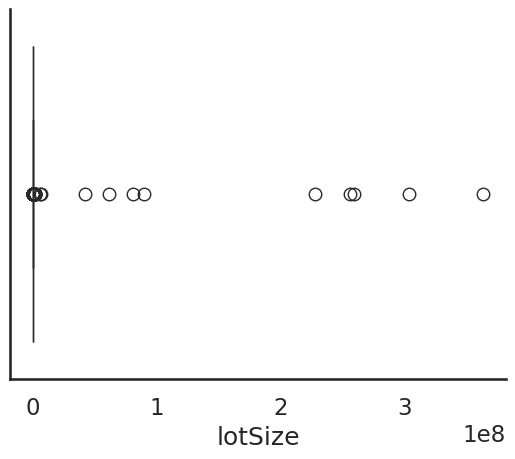

In [1862]:
sns.boxplot(x=df_keep["lotSize"])

<Axes: xlabel='livingArea'>

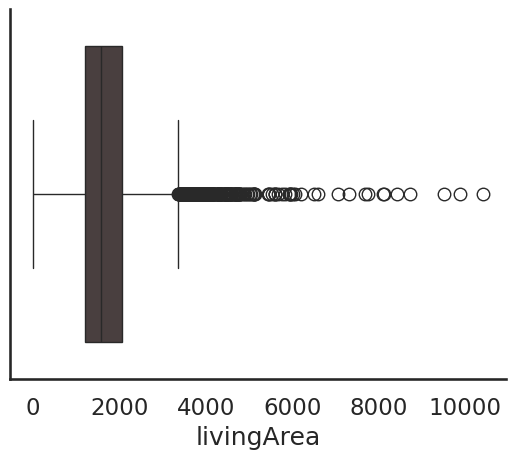

In [1863]:
sns.boxplot(x=df_keep["livingArea"])

In [1864]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile) for each column
Q1_living = df_keep['livingArea'].quantile(0.25)
Q3_living = df_keep['livingArea'].quantile(0.75)
IQR_living = Q3_living - Q1_living

Q1_lot = df_keep['lotSize'].quantile(0.25)
Q3_lot = df_keep['lotSize'].quantile(0.75)
IQR_lot = Q3_lot - Q1_lot

# Define the lower and upper bounds for outliers
lower_bound_living = Q1_living - 1.5 * IQR_living
upper_bound_living = Q3_living + 1.5 * IQR_living

lower_bound_lot = Q1_lot - 1.5 * IQR_lot
upper_bound_lot = Q3_lot + 1.5 * IQR_lot

# Filter the dataframe based on the IQR bounds for both columns
df_keep = df_keep.loc[
    (df_keep['livingArea'] >= lower_bound_living) & (df_keep['livingArea'] <= upper_bound_living) &
    (df_keep['lotSize'] >= lower_bound_lot) & (df_keep['lotSize'] <= upper_bound_lot)
]

<Axes: xlabel='lotSize'>

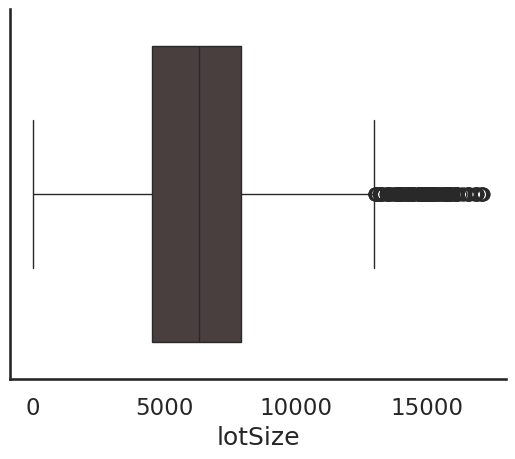

In [1865]:
sns.boxplot(x=df_keep["lotSize"])

<Axes: xlabel='livingArea'>

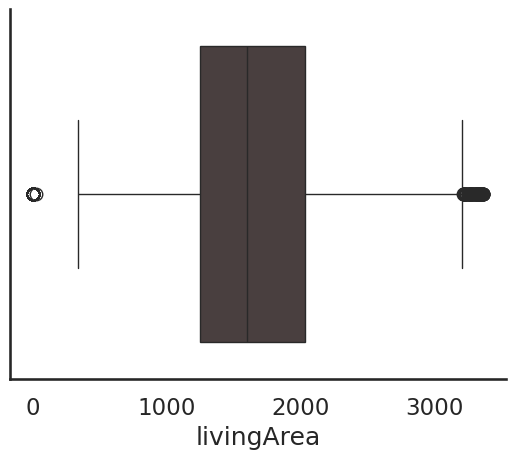

In [1866]:
sns.boxplot(x=df_keep["livingArea"])

In [1867]:
# Manually removing livingArea outlier using domain knowlege (a.k.a no one can live in a <1sqft space)
df_keep = df_keep.loc[df_keep['livingArea'] > 50]

In [1868]:
df_keep.describe()

,price,lotSize,livingArea,AnnualHOAFee,fullBathrooms,halfBathrooms,bedrooms,propertyTaxRate,yearBuilt,latitude,...,elevation,mean_daily_high_temperature,mean_daily_low_temperature,rainfall,population_density,park,motorway,supermarket,Costco,address/zipcode
count,5.602000e+03,5602.000000,5602.000000,5596.000000,5602.0,5602.0,5602.0,5602.000000,5602.0,5602.000000,...,5364.000000,5602.000000,5602.000000,5602.000000,5457.000000,5602.000000,5601.000000,5602.000000,5552.000000,5602.000000
mean,1.031875e+06,6431.753838,1708.832381,764.380450,1.372724,0.179222,3.226169,1.166291,1970.290253,35.330365,...,315.765101,73.690343,53.113406,13.536462,6209.437075,580.971590,2060.392378,1159.115535,5229.179336,92855.799536
std,5.881774e+05,3181.118758,573.568354,1750.939673,1.123013,0.389576,1.031589,0.056286,25.929216,1.608143,...,479.924138,4.655808,2.787886,4.492608,4327.548765,459.634232,1764.835536,1051.070747,3661.921452,1306.118395
min,2.000000e+05,0.000000,340.000000,0.000000,0.0,0.0,0.0,1.070000,1871.0,32.815190,...,7.000000,63.300000,41.700000,6.360000,240.540000,2.070710,23.637393,16.558101,151.610253,90045.000000
25%,4.700000e+05,4490.000000,1285.000000,0.000000,0.0,0.0,3.0,1.110000,1953.0,33.885346,...,52.000000,69.200000,51.300000,10.990000,2700.000000,293.632143,750.232977,600.242115,3005.707119,92011.000000
50%,9.600000e+05,6300.000000,1615.500000,0.000000,2.0,0.0,3.0,1.160000,1969.0,35.126569,...,164.000000,76.000000,53.800000,12.930000,4722.600000,484.777380,1633.175840,945.110716,4480.644389,93263.000000
75%,1.457125e+06,7884.750000,2051.500000,0.000000,2.0,0.0,4.0,1.210000,1988.0,36.837819,...,404.000000,77.675000,54.400000,16.000000,8205.000000,746.375102,2824.476866,1439.192806,6401.168495,93726.000000
max,2.500000e+06,17133.000000,3368.000000,11616.000000,6.0,3.0,32.0,1.240000,2024.0,38.748980,...,3970.000000,81.600000,58.500000,30.530000,19000.000000,8295.144736,15874.560938,18100.046897,39706.299003,95746.000000


<Axes: xlabel='livingArea'>

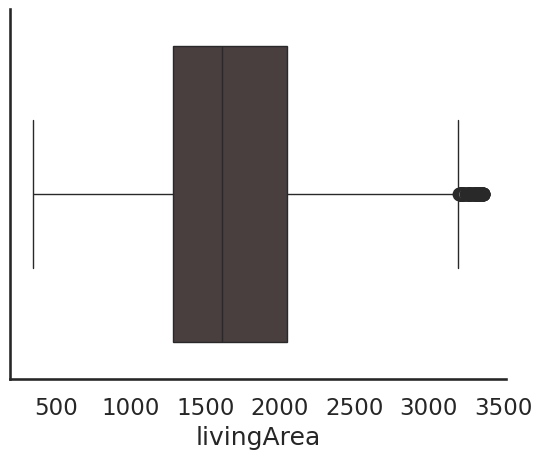

In [1869]:
sns.boxplot(x=df_keep["livingArea"])

## Create dummy variables

In [1870]:
df_keep.shape

(5602, 29)

In [1871]:
df_keep.dtypes

price                             int64
lotSize                         float64
livingArea                      float64
hasGarage                       boolean
hasAttachedProperty             boolean
hasView                         boolean
hasHOA                          boolean
AnnualHOAFee                    float64
fullBathrooms                     Int64
halfBathrooms                     Int64
bedrooms                          Int64
city                             object
homeType                       category
propertyTaxRate                 float64
yearBuilt                         Int64
hasHomeWarranty                 boolean
latitude                        float64
longitude                       float64
elevation                       float64
mean_daily_high_temperature     float64
mean_daily_low_temperature      float64
rainfall                        float64
population_density              float64
park                            float64
motorway                        float64


Create Dummy Variables for categorical features

In [1872]:
df_dummies = df_keep.copy()
cat_cols = ["fullBathrooms", "halfBathrooms", "bedrooms", "city", "homeType", "yearBuilt"]
bool_cols = ["hasGarage", "hasAttachedProperty", "hasView", "hasHomeWarranty", "hasHOA"]
df_dummies[cat_cols] = df_keep[cat_cols].astype("category")
df_dummies[bool_cols] = df_keep[bool_cols].astype("boolean")

In [1873]:
df_dummies.dtypes

price                             int64
lotSize                         float64
livingArea                      float64
hasGarage                       boolean
hasAttachedProperty             boolean
hasView                         boolean
hasHOA                          boolean
AnnualHOAFee                    float64
fullBathrooms                  category
halfBathrooms                  category
bedrooms                       category
city                           category
homeType                       category
propertyTaxRate                 float64
yearBuilt                      category
hasHomeWarranty                 boolean
latitude                        float64
longitude                       float64
elevation                       float64
mean_daily_high_temperature     float64
mean_daily_low_temperature      float64
rainfall                        float64
population_density              float64
park                            float64
motorway                        float64


In [1874]:
# Confirm there are no more null values
df_dummies.isna().sum()
df_dummies = df_dummies.dropna()

In [1875]:
df_dummies = pd.get_dummies(df_dummies)

In [1876]:
display(df_dummies)

,price,lotSize,livingArea,hasGarage,hasAttachedProperty,hasView,hasHOA,AnnualHOAFee,propertyTaxRate,hasHomeWarranty,...,address/streetAddress_9901 Lullaby Ln,address/streetAddress_991 Phillips Way,address/streetAddress_9912 Pacific Ave,address/streetAddress_9916 N Meridian Ave,address/streetAddress_992 E Buckhill Rd,address/streetAddress_9925 N Granville Ave,address/streetAddress_9926 N Ann Ave,address/streetAddress_996 S Hilda St,address/streetAddress_997 Glennan Dr,address/streetAddress_999 Portola Dr
0,1500000,5767.0,1413.0,True,False,False,True,7584.0,1.18,False,...,False,False,False,False,False,False,False,False,False,False
1,1675000,2501.0,1892.0,True,False,True,False,0.0,1.16,False,...,False,False,False,False,False,False,False,False,False,False
4,1170000,1433.0,1440.0,True,True,True,True,4344.0,1.07,False,...,False,False,False,False,False,False,False,False,False,False
5,2475000,5022.0,2897.0,True,False,True,False,0.0,1.16,False,...,False,False,False,False,False,False,False,False,False,False
7,2221711,8150.0,2557.0,True,False,True,False,0.0,1.16,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9133,750000,5820.0,936.0,False,False,False,False,0.0,1.16,False,...,False,False,False,False,False,False,False,False,False,False
9134,775000,10202.0,2083.0,True,False,False,True,1968.0,1.09,False,...,False,False,False,False,False,False,False,False,False,False
9136,690000,4791.0,1164.0,True,False,False,False,0.0,1.24,False,...,False,False,False,False,False,False,False,False,False,False
9138,785000,960.0,1056.0,True,False,True,True,3000.0,1.24,False,...,False,False,False,False,False,False,False,False,False,False


# Models

## Old Model

My best performing model

In [1877]:
df_dummies = df_keep.copy()
cat_cols = ["city", "homeType"]
bool_cols = ["hasGarage", "hasAttachedProperty", "hasView", "hasHomeWarranty", "hasHOA"]
df_dummies[cat_cols] = df_dummies[cat_cols].astype("category")
df_dummies[bool_cols] = df_dummies[bool_cols].astype("boolean")
df_dummies.dropna(how='any', inplace=True)
df_dummies.drop(["city", 'elevation', 'mean_daily_high_temperature',
                 'mean_daily_low_temperature', 'rainfall', 'population_density', 'park', 'motorway', 'supermarket', 'Costco', "address/streetAddress", "address/zipcode"], axis=1, inplace=True)

In [1878]:
def remove_unused_categories(df):
    for col in df.columns:
        if isinstance(df[col].dtype, pd.CategoricalDtype):
            df[col] = df[col].cat.remove_unused_categories()
    return df

In [1879]:
df_dummies = remove_unused_categories(df_dummies)

In [1880]:
# Features that we are feeding into the model
df_dummies.columns

Index(['price', 'lotSize', 'livingArea', 'hasGarage', 'hasAttachedProperty',
       'hasView', 'hasHOA', 'AnnualHOAFee', 'fullBathrooms', 'halfBathrooms',
       'bedrooms', 'homeType', 'propertyTaxRate', 'yearBuilt',
       'hasHomeWarranty', 'latitude', 'longitude'],
      dtype='object')

In [1881]:
df_dummies.shape

(5233, 17)

### Create a correlation plot

In [1882]:
corr_df = df_dummies.copy()

<Axes: >

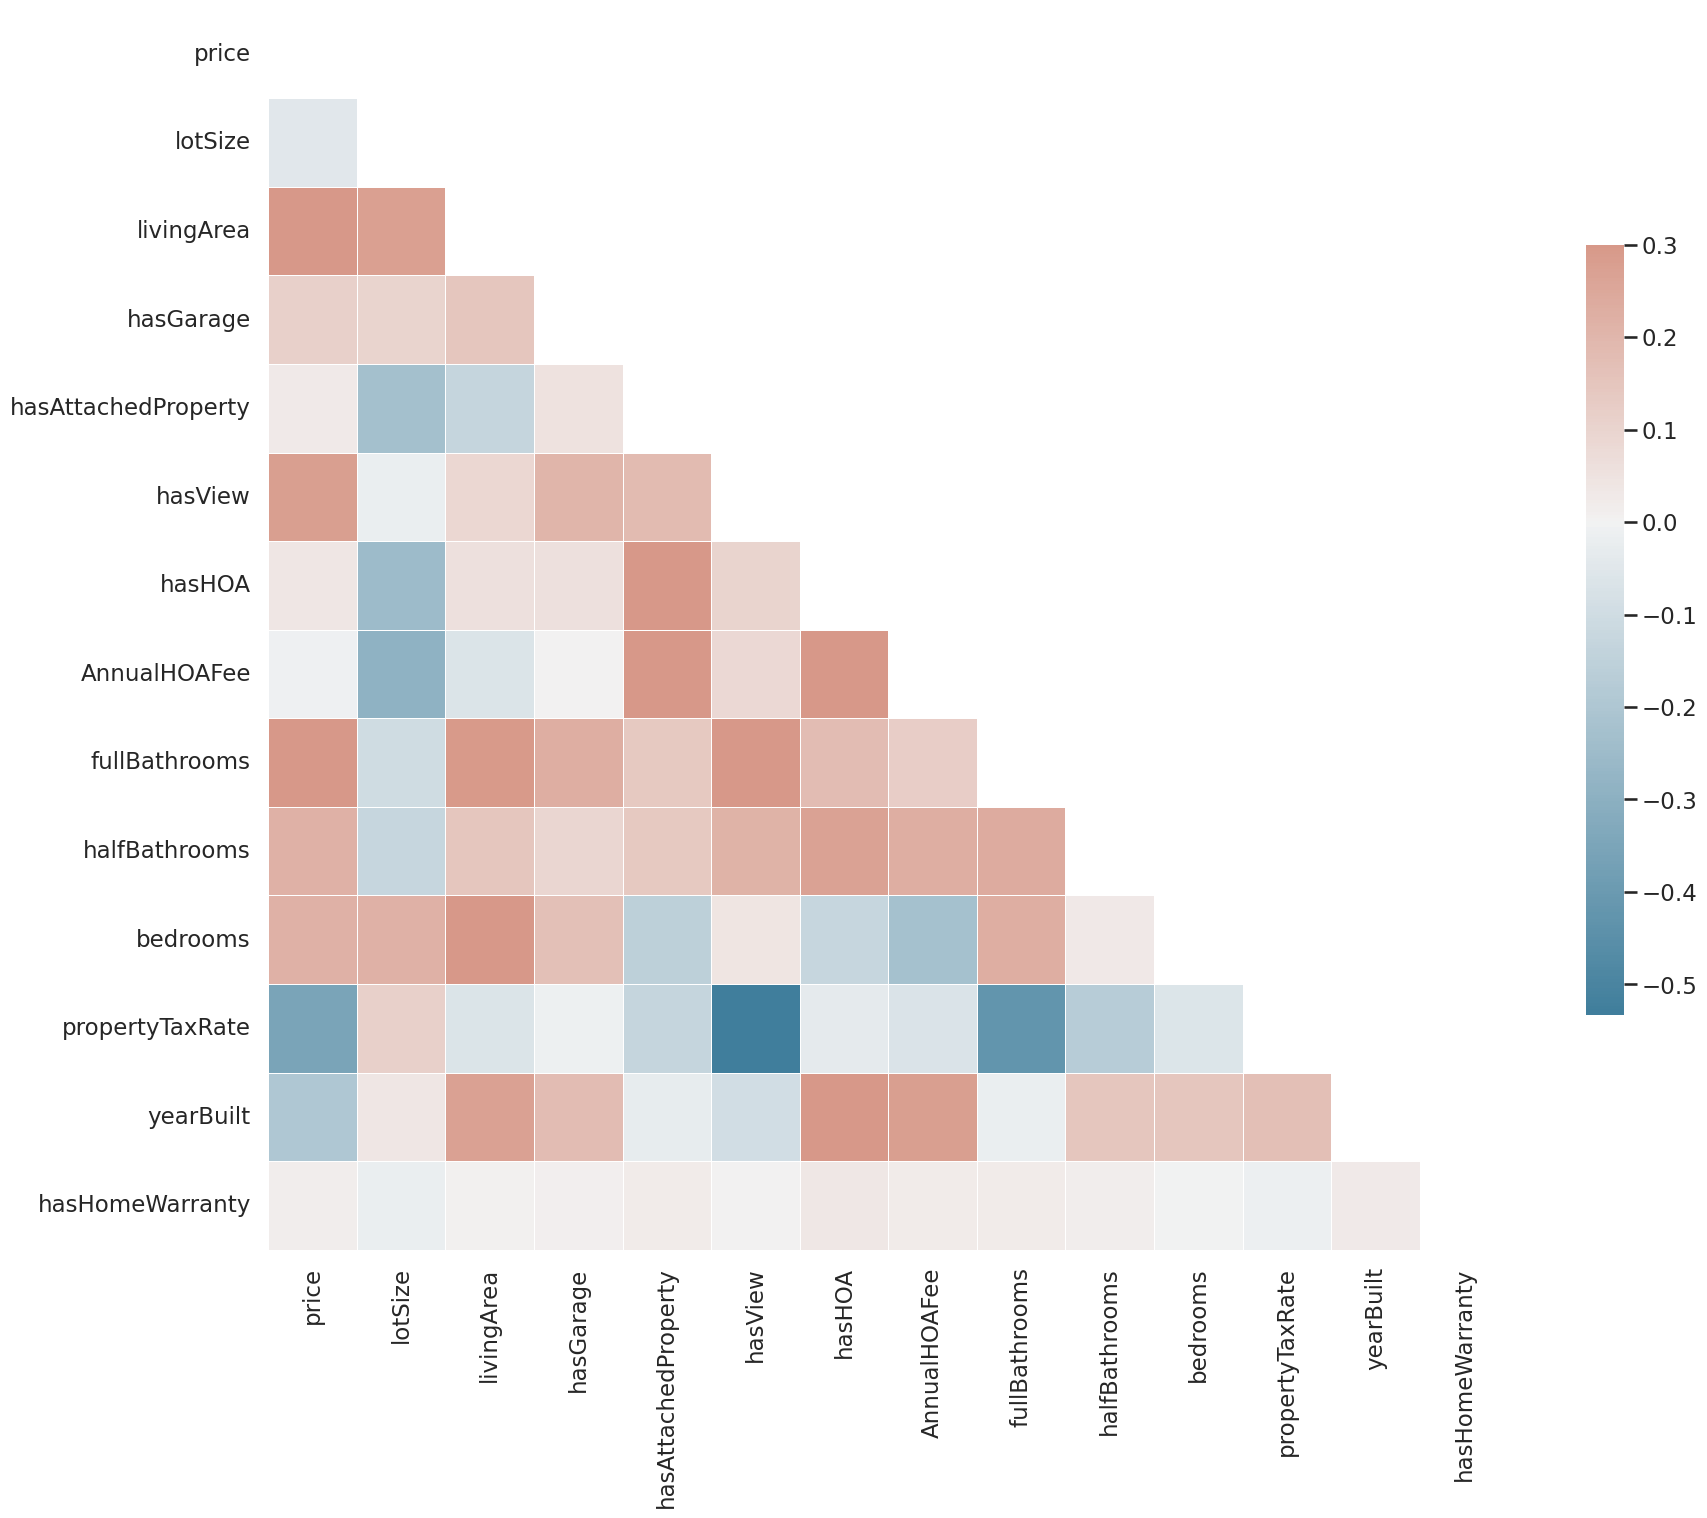

In [1883]:
# Drop some features out of the correlation plot to make it more readable
corr = corr_df.drop(["homeType", "latitude", "longitude"],axis=1).corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(20, 20))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# plt.savefig(figure_path+"3_corr.png", dpi=100, transparent=True)

### Train Model

In [1884]:
df_dummies = pd.get_dummies(df_dummies)

In [1885]:
X = df_dummies.drop("price", axis=1)
y = df_dummies["price"]

In [1886]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=5)

In [1887]:
eval_set = [(X_train, y_train), (X_test, y_test)]

In [1888]:
# xgb = XGBRegressor(n_estimators=1000, early_stopping_rounds=50)
# xgb.fit(X_train, y_train, eval_set=eval_set, verbose=False)
xgb_model = xgb.XGBRegressor(n_estimators=1000, max_depth=5, min_child_weight=5, learning_rate=0.01, reg_alpha=0.1, reg_lambda=0.1)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [1889]:
print(xgb_model.score(X_train, y_train))
print(xgb_model.score(X_test, y_test))

0.9350058436393738
0.8866285681724548


In [1890]:
print("train rmse:", root_mean_squared_error(y_train, xgb_model.predict(X_train)))
print("test rmse:", root_mean_squared_error(y_test, xgb_model.predict(X_test)))

print("train mse:", mean_squared_error(y_train, xgb_model.predict(X_train)))
print("test mse:", mean_squared_error(y_test, xgb_model.predict(X_test)))

train rmse: 149671.2469658597
test rmse: 197826.55219522747
train mse: 22401482168.315365
test mse: 39135344753.45106


Plot Residual Values

Text(0.5, 1.0, 'Predicted Values vs Residuals')

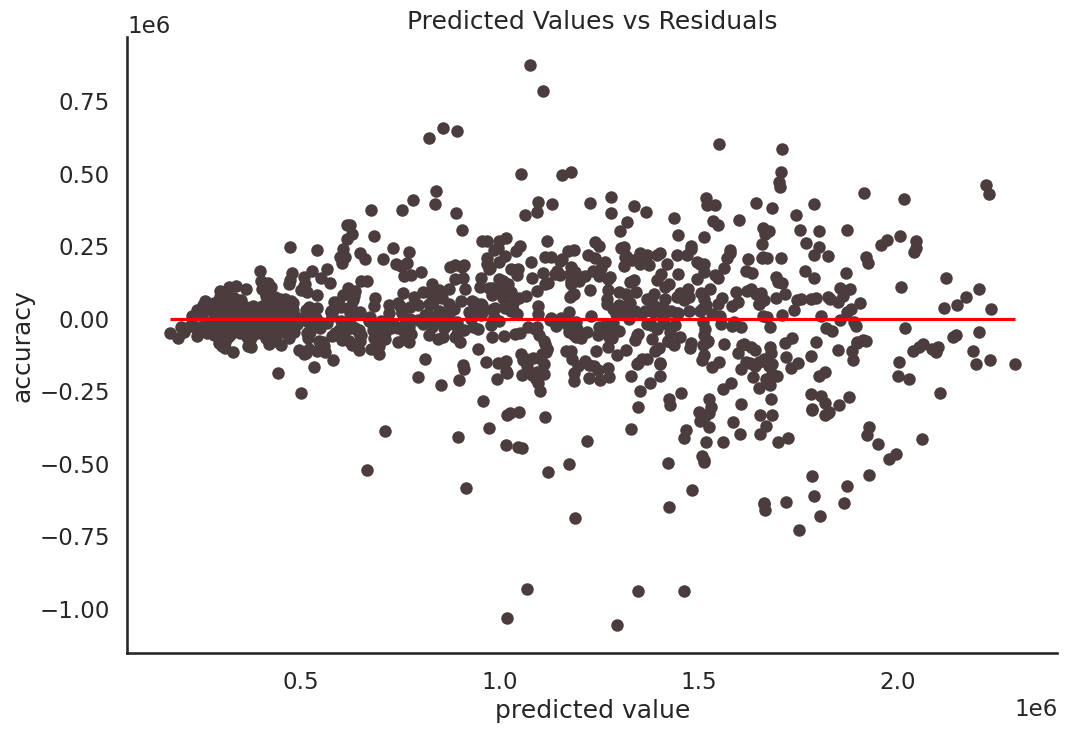

In [1891]:
pred = xgb_model.predict(X_test)
true = y_test
acc = pred - true
fig, ax = plt.subplots(figsize=(12,8))
sns.scatterplot(x=pred, y=acc, linewidth=0)
ax.hlines(y=0, xmin=pred.min(), xmax=pred.max(), colors='red')
plt.xlabel("predicted value")
plt.ylabel("accuracy")
plt.title("Predicted Values vs Residuals")
# plt.savefig(figure_path+"xgb3_residual.png", dpi=300, transparent=True)
# files.download(figure_path+"xgb3_residual.png")

Plot feature importance

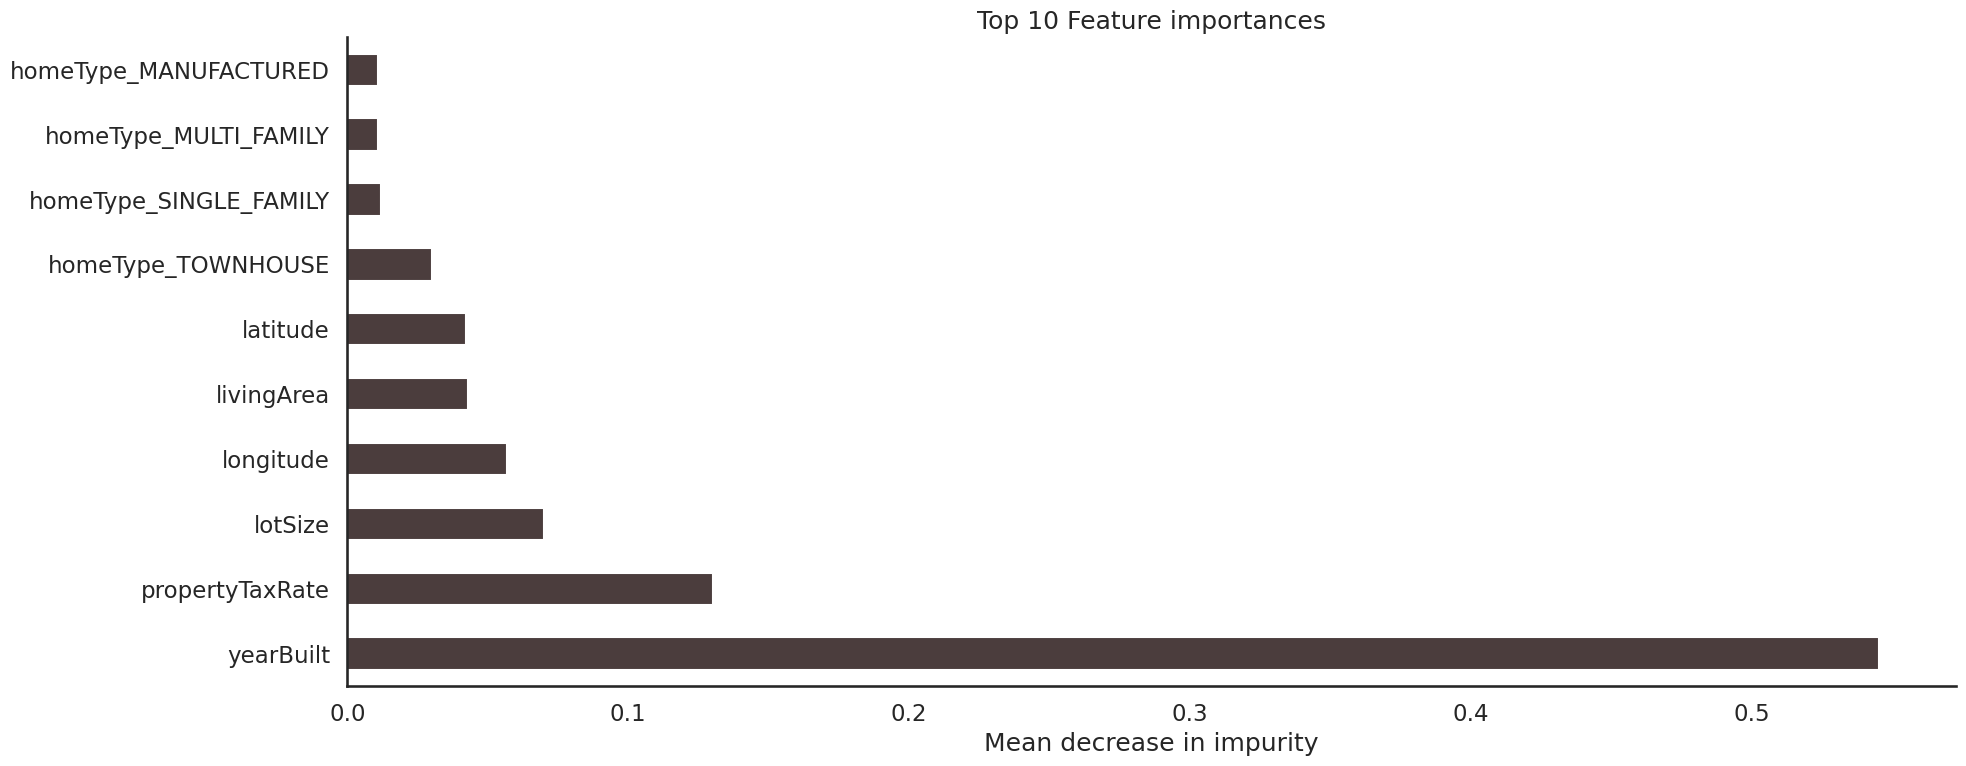

In [1892]:
t10_features = sorted(xgb_model.feature_importances_, reverse=True)[:10]
t10_features_names = sorted(xgb_model.feature_names_in_, reverse=True)[:10]
xgb_importances = pd.Series(t10_features, index=t10_features_names)

fig, ax = plt.subplots(figsize=(20,8))
xgb_importances.plot.barh(ax=ax)
ax.set_title("Top 10 Feature importances")
ax.set_xlabel("Mean decrease in impurity")
plt.tight_layout()
# plt.savefig(figure_path+"xgb3_importance.png", dpi=300, transparent=True)
# files.download(figure_path+"xgb3_importance.png")

Plot least important features

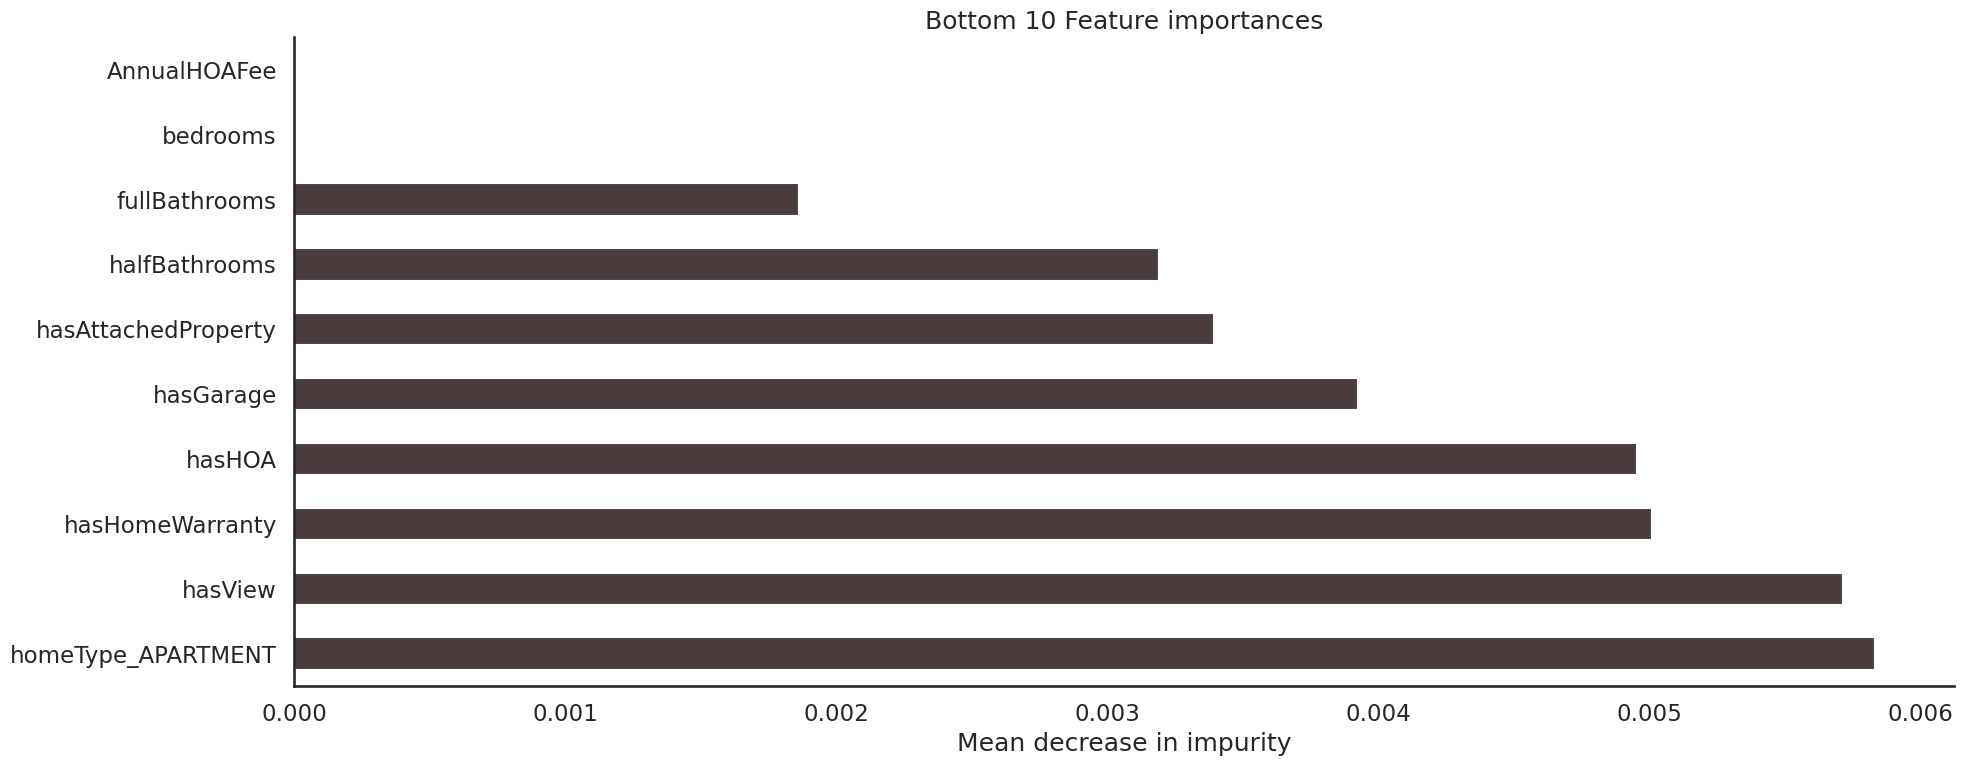

In [1893]:
l10_features = sorted(xgb_model.feature_importances_, reverse=True)[-10:]
l10_features_names = sorted(xgb_model.feature_names_in_, reverse=True)[-10:]
xgb_importances = pd.Series(l10_features, index=l10_features_names)

fig, ax = plt.subplots(figsize=(20,8))
xgb_importances.plot.barh(ax=ax)
ax.set_title("Bottom 10 Feature importances")
ax.set_xlabel("Mean decrease in impurity")
plt.tight_layout()
# plt.savefig(figure_path+"xgb3_limportance.png", dpi=300, transparent=True)
# files.download(figure_path+"xgb3_limportance.png")

Text(0, 0.5, 'features')

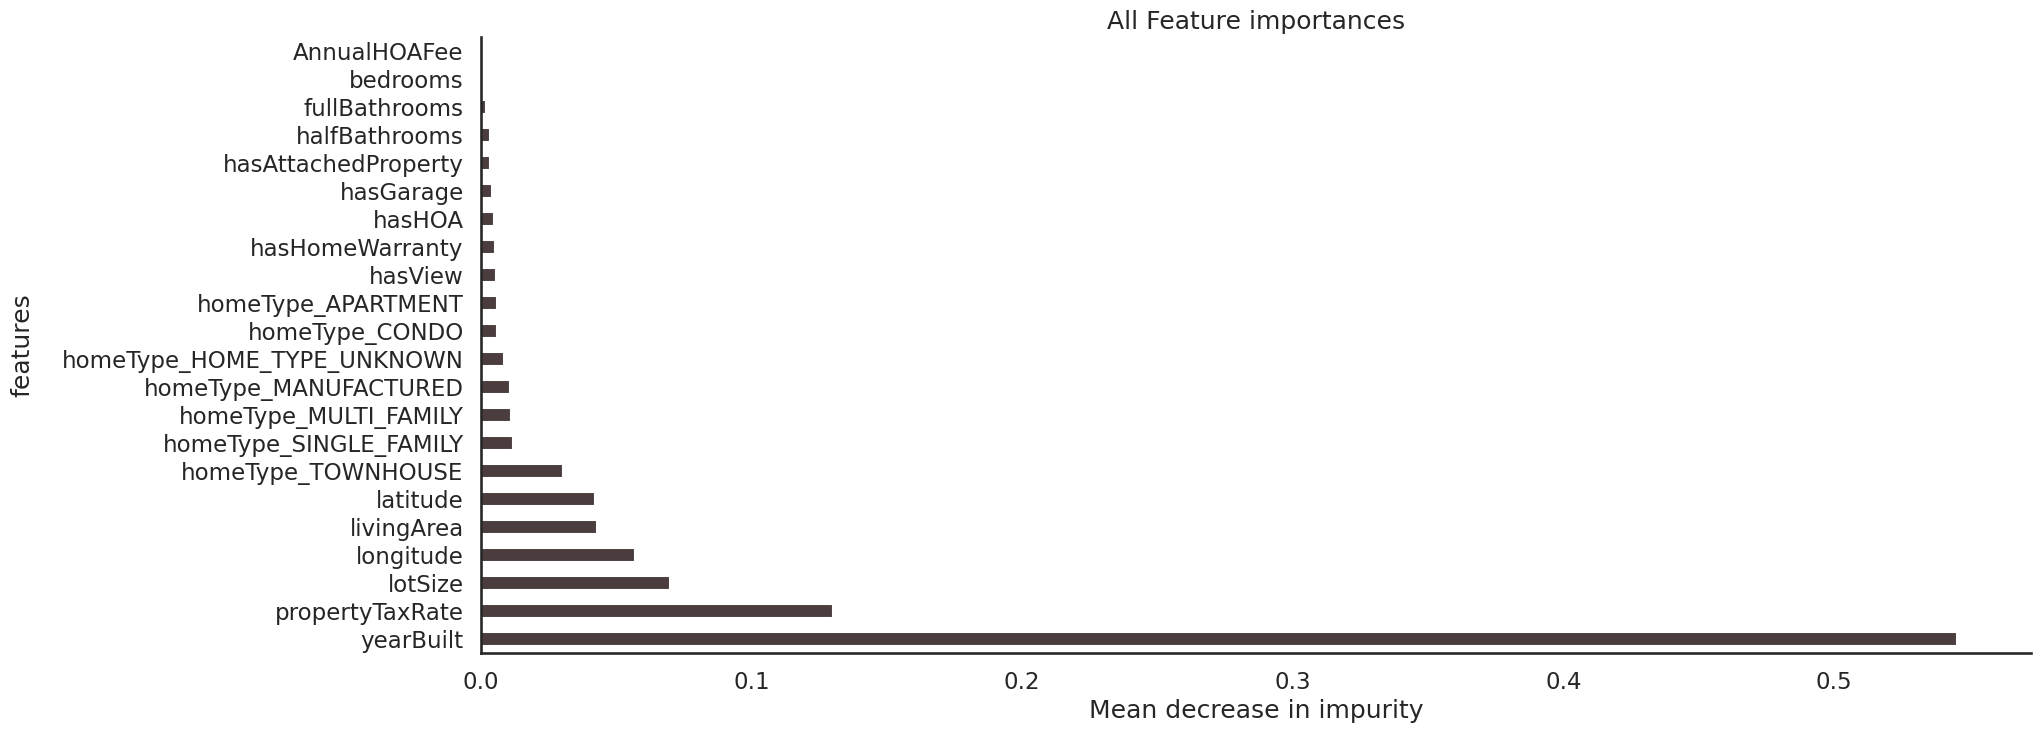

In [1894]:
all_features = sorted(xgb_model.feature_importances_, reverse=True)
all_features_names = sorted(xgb_model.feature_names_in_, reverse=True)
xgb_importances = pd.Series(all_features, index=all_features_names)

fig, ax = plt.subplots(figsize=(20,8))
xgb_importances.plot.barh(ax=ax)
ax.set_title("All Feature importances")
ax.set_xlabel("Mean decrease in impurity")
plt.ylabel("features", labelpad=20)
# plt.savefig(figure_path+"xgb3_aimportance.png", dpi=300, transparent=True)

#### Visualize Shap

In [1895]:
# SHAP requires all values to be floats
X_train_float = X_train.select_dtypes(include=['int64', 'float64']).astype('float64')
X_test_float = X_test.select_dtypes(include=['int64', 'float64']).astype('float64')

In [1896]:
X_train_float.dtypes

lotSize            float64
livingArea         float64
AnnualHOAFee       float64
fullBathrooms      float64
halfBathrooms      float64
bedrooms           float64
propertyTaxRate    float64
yearBuilt          float64
latitude           float64
longitude          float64
dtype: object

In [1897]:
# Initialize the SHAP explainer
explainer = shap.TreeExplainer(xgb_model)

# Calculate SHAP values for the test data
shap_values = explainer.shap_values(X_test)

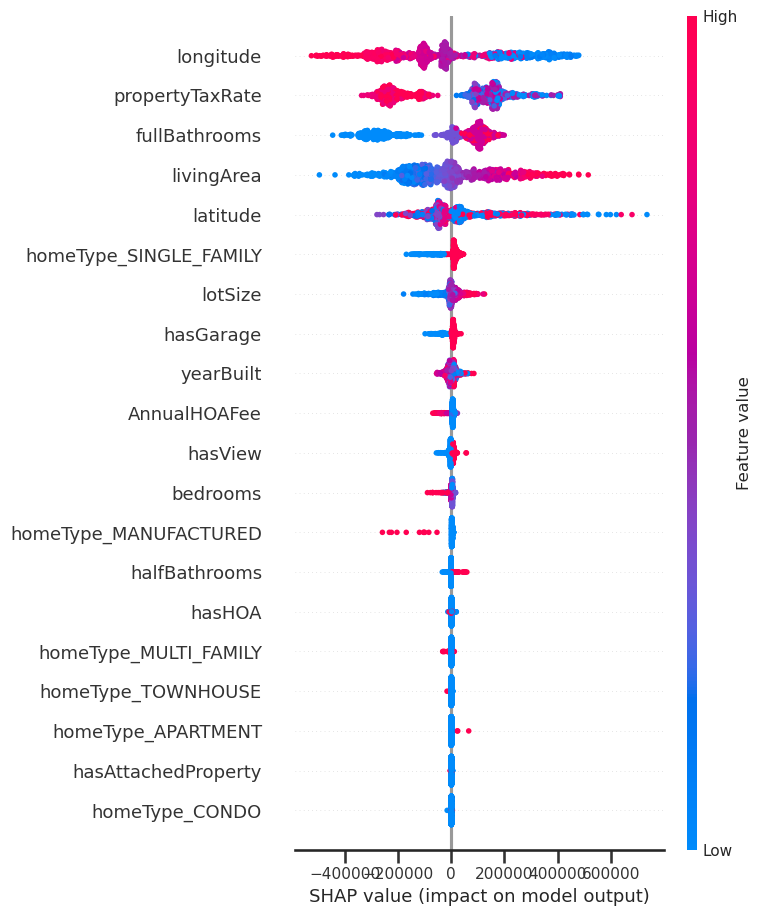

In [1898]:
# Plot SHAP summary plot to visualize feature importance
# Create figure with specific size
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test, show=False)
plt.tight_layout()
# plt.savefig('shap_summary_plot.png', dpi=300, transparent=True)
plt.show()
plt.close()
# files.download('shap_summary_plot.png')

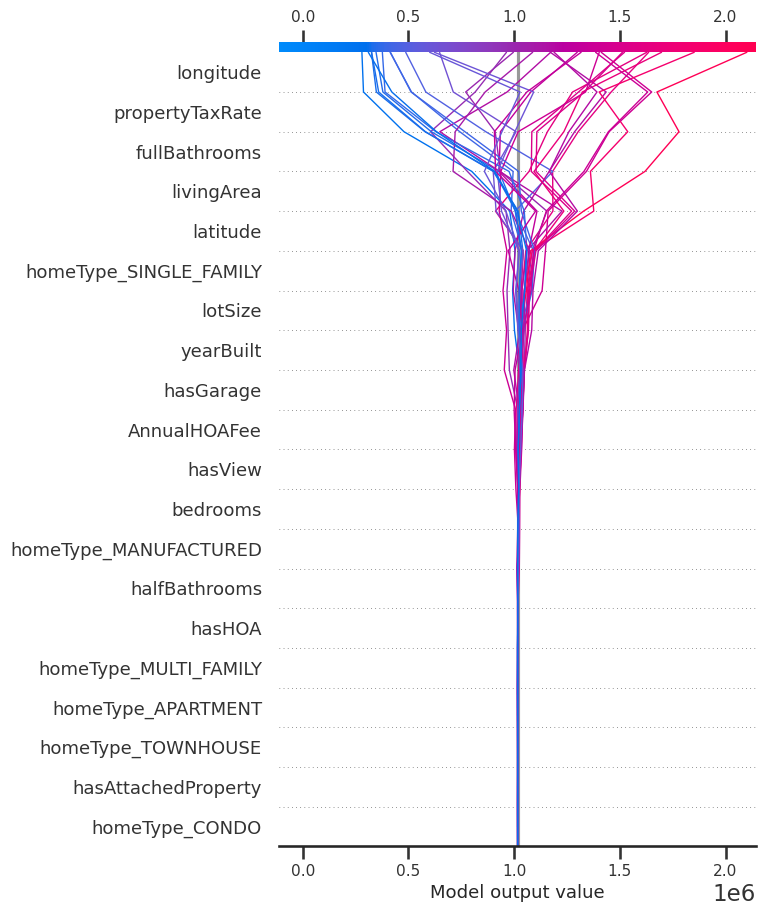

In [1899]:
plt.figure(figsize=(12, 8))
shap.decision_plot(explainer.expected_value, shap_values[0:30], X_test.values[0:30], feature_names=list(X_test.columns), show=False)
plt.tight_layout()
# plt.savefig('shap_decision_plot.png', transparent=True, bbox_inches='tight', dpi=300)
plt.show()
plt.close()
# files.download('shap_decision_plot.png')

## New Model

In [1900]:
pd.set_option("display.max_columns", None)

In [1901]:
df_keep.head()

,price,lotSize,livingArea,hasGarage,hasAttachedProperty,hasView,hasHOA,AnnualHOAFee,fullBathrooms,halfBathrooms,bedrooms,city,homeType,propertyTaxRate,yearBuilt,hasHomeWarranty,latitude,longitude,elevation,mean_daily_high_temperature,mean_daily_low_temperature,rainfall,population_density,park,motorway,supermarket,Costco,address/streetAddress,address/zipcode
0,1500000,5767.0,1413.0,True,False,False,True,7584.0,2,1,2,san francisco,CONDO,1.18,2009,False,37.757065,-122.388860,52.0,64.1,51.3,22.89,18634.65,174.119369,317.501951,1462.133889,2429.183636,1175 Tennessee St,94107
1,1675000,2501.0,1892.0,True,False,True,False,0.0,2,1,3,redondo beach,SINGLE_FAMILY,1.16,1988,False,33.860510,-118.381226,62.0,70.6,54.4,13.76,12000.00,244.301924,3751.007508,736.180364,4379.595284,1748 Havemeyer Ln,90278
4,1170000,1433.0,1440.0,True,True,True,True,4344.0,2,1,3,newport beach,TOWNHOUSE,1.07,1963,False,33.628270,-117.930190,10.0,68.2,57.3,9.43,1600.00,376.815869,2433.458251,1072.542128,8357.130033,436 Orion Way,92663
5,2475000,5022.0,2897.0,True,False,True,False,0.0,3,0,3,los angeles,SINGLE_FAMILY,1.16,1928,False,34.104156,-118.365524,522.0,77.0,54.0,17.17,8205.00,948.239524,2878.467283,709.411987,9754.389868,1725 Mount Olympus Dr,90046
6,1600000,6493.0,1493.0,True,True,True,True,10800.0,2,0,2,la jolla,CONDO,1.17,2004,False,32.846115,-117.276566,NaN,72.0,56.0,12.77,NaN,265.398485,2554.438443,460.551728,5524.348606,848 Prospect St SUITE E,92037


In [1902]:
pd.set_option("display.max_columns", 20)

In [1903]:
df_dummies = df_keep.copy()
cat_cols = ["city", "homeType"]
bool_cols = ["hasGarage", "hasAttachedProperty", "hasView", "hasHomeWarranty", "hasHOA"]
df_dummies[cat_cols] = df_dummies[cat_cols].astype("category")
df_dummies[bool_cols] = df_dummies[bool_cols].astype("boolean")
df_dummies.dropna(how='any', inplace=True)
df_dummies.drop(["city", "latitude", "longitude", "address/streetAddress", "address/zipcode"], axis=1, inplace=True)

df_dummies = remove_unused_categories(df_dummies)

In [1904]:
# Features that we are feeding into the model
df_dummies.columns

Index(['price', 'lotSize', 'livingArea', 'hasGarage', 'hasAttachedProperty',
       'hasView', 'hasHOA', 'AnnualHOAFee', 'fullBathrooms', 'halfBathrooms',
       'bedrooms', 'homeType', 'propertyTaxRate', 'yearBuilt',
       'hasHomeWarranty', 'elevation', 'mean_daily_high_temperature',
       'mean_daily_low_temperature', 'rainfall', 'population_density', 'park',
       'motorway', 'supermarket', 'Costco'],
      dtype='object')

In [1905]:
df_dummies.dtypes

price                             int64
lotSize                         float64
livingArea                      float64
hasGarage                       boolean
hasAttachedProperty             boolean
hasView                         boolean
hasHOA                          boolean
AnnualHOAFee                    float64
fullBathrooms                     Int64
halfBathrooms                     Int64
bedrooms                          Int64
homeType                       category
propertyTaxRate                 float64
yearBuilt                         Int64
hasHomeWarranty                 boolean
elevation                       float64
mean_daily_high_temperature     float64
mean_daily_low_temperature      float64
rainfall                        float64
population_density              float64
park                            float64
motorway                        float64
supermarket                     float64
Costco                          float64
dtype: object

In [1906]:
df_dummies.shape

(5233, 24)

### Create a correlation plot

In [1907]:
corr_df = df_dummies.copy()

<Axes: >

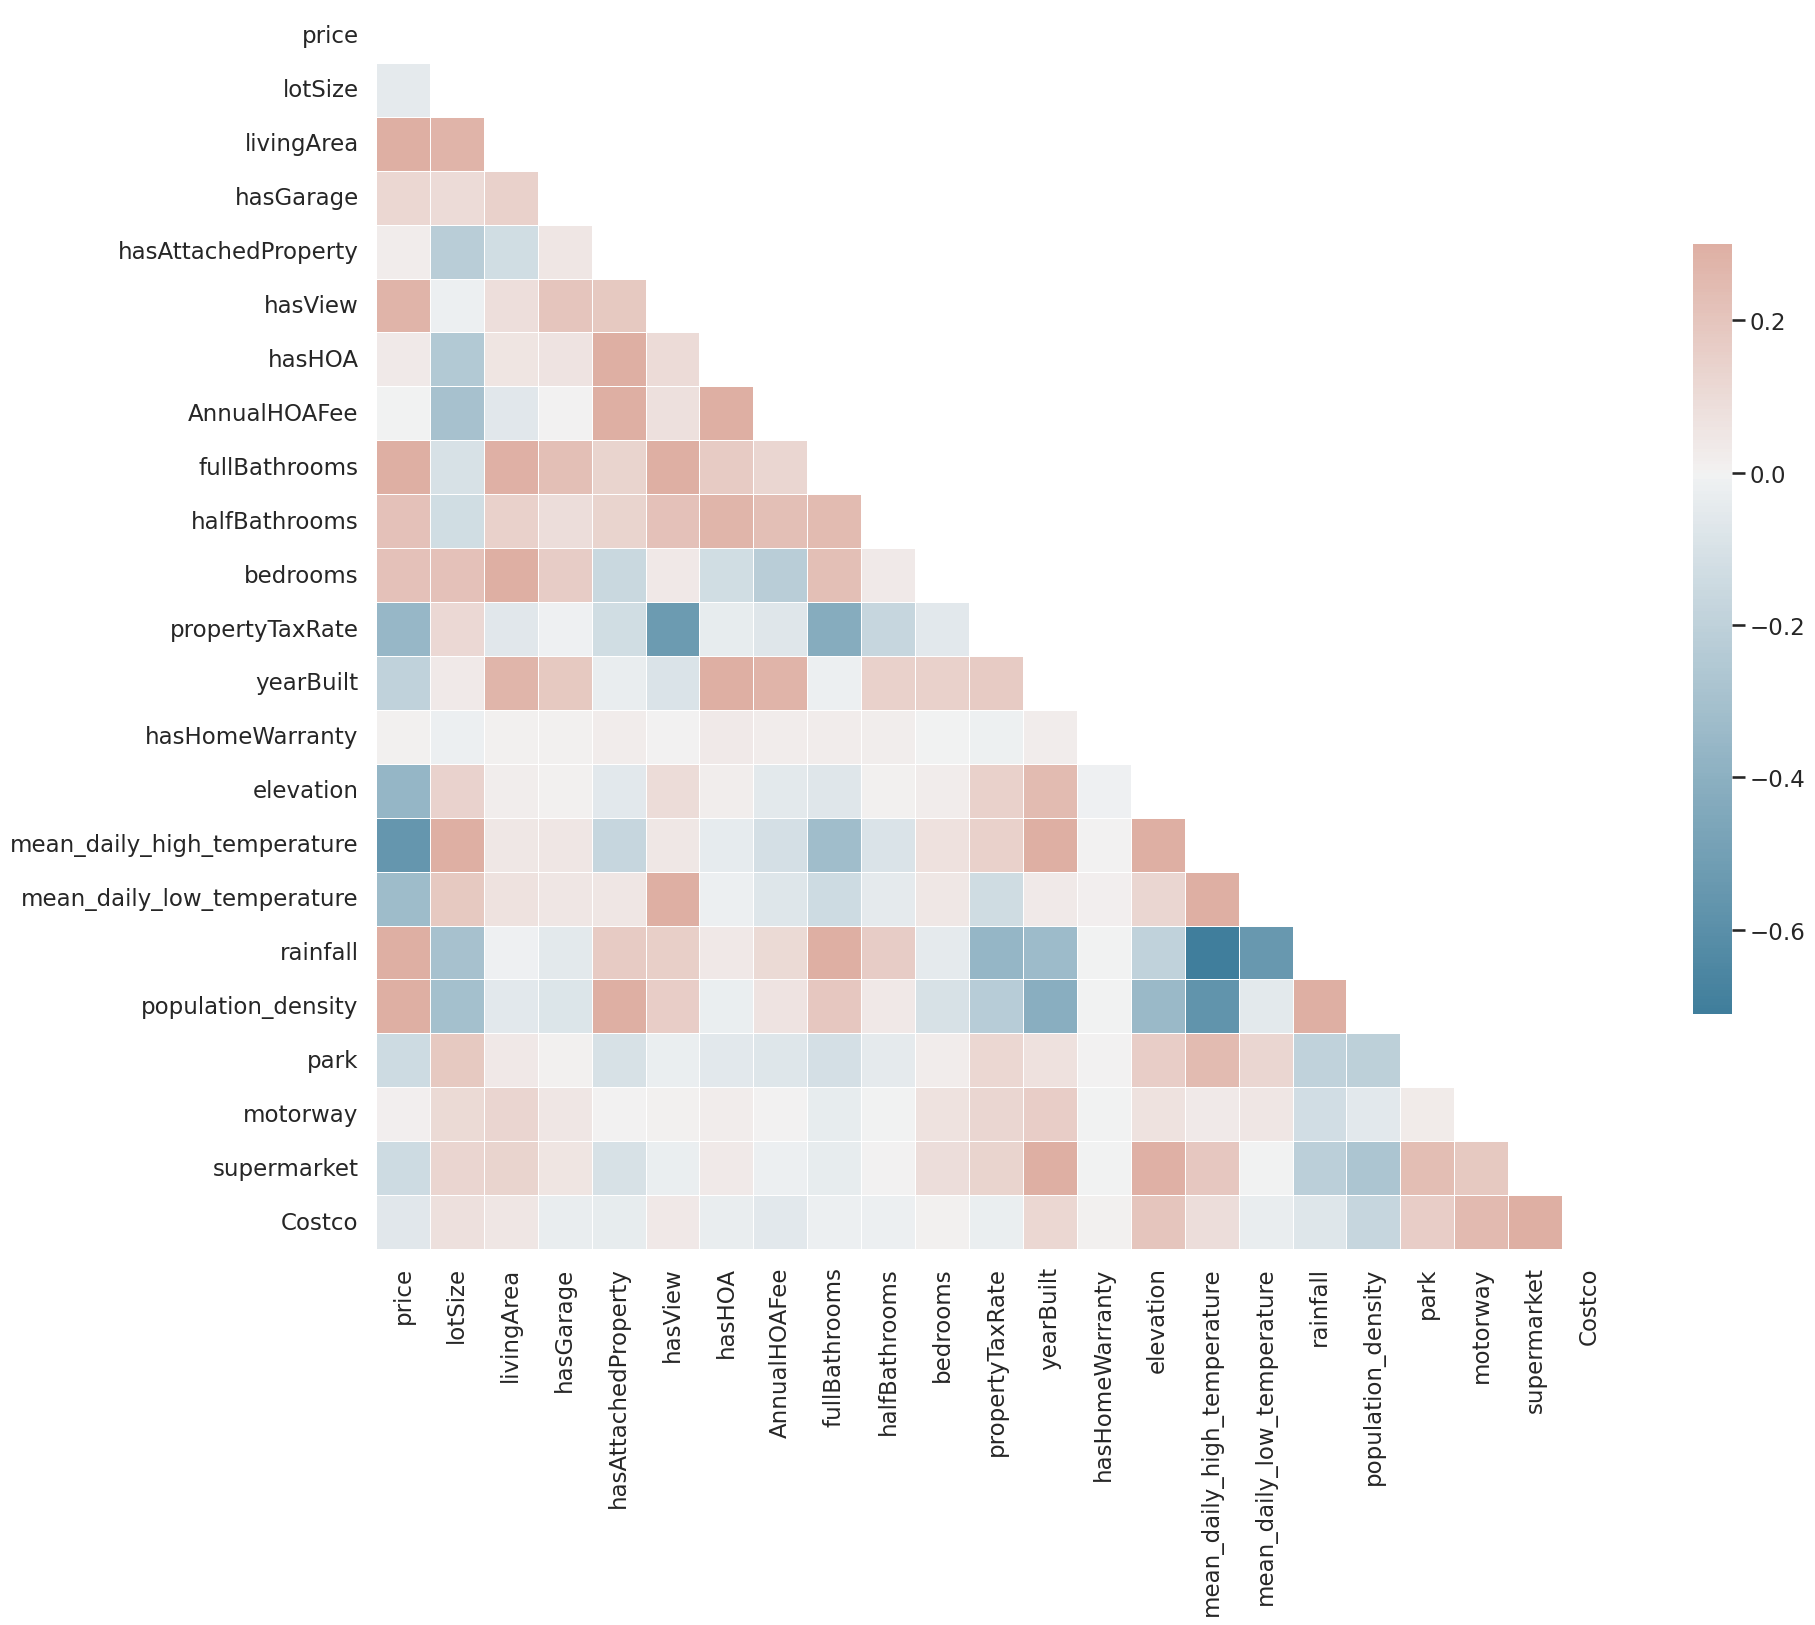

In [1908]:
# Drop some features out of the correlation plot to make it more readable
corr = corr_df.drop(["homeType"],axis=1).corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(20, 20))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# plt.savefig(figure_path+"3_corr.png", dpi=100, transparent=True)

### Train Model

In [1909]:
df_dummies = pd.get_dummies(df_dummies)

In [1910]:
X = df_dummies.drop("price", axis=1)
y = df_dummies["price"]

In [1911]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=5)

#### XGBoost

In [1912]:
xgb_model = xgb.XGBRegressor(n_estimators=1000, max_depth=5, min_child_weight=5, learning_rate=0.01, reg_alpha=0.1, reg_lambda=0.1)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [1913]:
print(xgb_model.score(X_train, y_train))
print(xgb_model.score(X_test, y_test))

0.9395419955253601
0.8820532560348511


In [1914]:
print("train rmse:", root_mean_squared_error(y_train, xgb_model.predict(X_train)))
print("test rmse:", root_mean_squared_error(y_test, xgb_model.predict(X_test)))

print("train mse:", mean_squared_error(y_train, xgb_model.predict(X_train)))
print("test mse:", mean_squared_error(y_test, xgb_model.predict(X_test)))

train rmse: 144353.80475398368
test rmse: 201778.89465489003
train mse: 20838020946.951244
test mse: 40714722328.14921


In [1915]:
def save_xgboost_model(
    model: xgb.XGBRegressor,
    feature_names: List[str],
    save_path: str,
    model_name: str = "model"
) -> None:
    """
    Save XGBoost model and its feature names to disk.
    
    Args:
        model: Trained XGBoost model
        feature_names: List of feature names used during training
        save_path: Directory to save the model files
        model_name: Base name for the saved files
    """
    # Create directory if it doesn't exist
    os.makedirs(save_path, exist_ok=True)
    
    # Construct file paths
    model_file = os.path.join(save_path, f"{model_name}.json")
    features_file = os.path.join(save_path, f"{model_name}_features.json")
    
    # Save the model using native XGBoost format
    model.save_model(model_file)
    
    # Save feature names and metadata
    with open(features_file, 'w') as f:
        json.dump({
            'feature_names': feature_names,
            'model_type': type(model).__name__,
            'xgboost_version': xgb.__version__  # Get version from xgboost package
        }, f)
    
    print(f"Model saved to: {model_file}")
    print(f"Features saved to: {features_file}")

In [1916]:
save_xgboost_model(
    model=xgb_model,
    feature_names=list(X_train.columns),
    save_path='models',
    model_name='avm_model'
)

Model saved to: models/avm_model.json
Features saved to: models/avm_model_features.json


Random Forest Model

In [1917]:
# Preprocessing as in your XGBoost code
df_dummies = df_keep.copy()
cat_cols = ["city", "homeType"]
bool_cols = ["hasGarage", "hasAttachedProperty", "hasView", "hasHomeWarranty", "hasHOA"]
df_dummies[cat_cols] = df_dummies[cat_cols].astype("category")
df_dummies[bool_cols] = df_dummies[bool_cols].astype("boolean")
df_dummies.dropna(how='any', inplace=True)
df_dummies.drop(["city", "latitude", "longitude", "address/streetAddress", "address/zipcode"], axis=1, inplace=True)

df_dummies = remove_unused_categories(df_dummies)

df_dummies = pd.get_dummies(df_dummies)

# Split the data into features (X) and target (y)
X = df_dummies.drop("price", axis=1)
y = df_dummies["price"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=5)

# Create and train Random Forest model
rf = RandomForestRegressor(n_estimators=1000, max_depth=10, random_state=5)
rf.fit(X_train, y_train)

# Model evaluation
print(f"Train R^2: {rf.score(X_train, y_train)}")
print(f"Test R^2: {rf.score(X_test, y_test)}")

print(f"Train RMSE: {mean_squared_error(y_train, rf.predict(X_train), squared=False)}")
print(f"Test RMSE: {mean_squared_error(y_test, rf.predict(X_test), squared=False)}")

print(f"Train MSE: {mean_squared_error(y_train, rf.predict(X_train))}")
print(f"Test MSE: {mean_squared_error(y_test, rf.predict(X_test))}")

Train R^2: 0.9391826894894458
Test R^2: 0.8701160852206898


/home/bbae/miniconda3/envs/avm/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/bbae/miniconda3/envs/avm/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Train RMSE: 144782.10854114182
Test RMSE: 211743.69274692805
Train MSE: 20961858953.618973
Test MSE: 44835391418.10547


Plot Residual Values

Text(0.5, 1.0, 'Predicted Values vs Residuals')

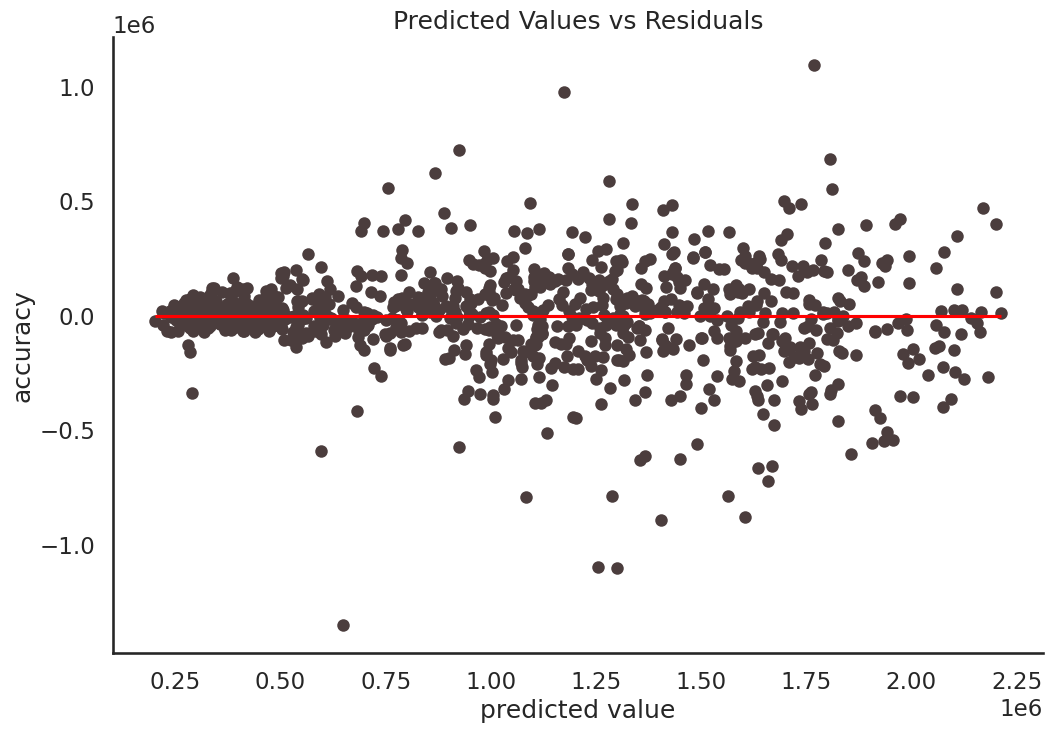

In [1918]:
pred = xgb_model.predict(X_test)
true = y_test
acc = pred - true
fig, ax = plt.subplots(figsize=(12,8))
sns.scatterplot(x=pred, y=acc, linewidth=0)
ax.hlines(y=0, xmin=pred.min(), xmax=pred.max(), colors='red')
plt.xlabel("predicted value")
plt.ylabel("accuracy")
plt.title("Predicted Values vs Residuals")
# plt.savefig(figure_path+"xgb_newdata_residual.png", dpi=300, transparent=True)
# files.download(figure_path+"xgb_newdata_residual.png")

Plot feature importance

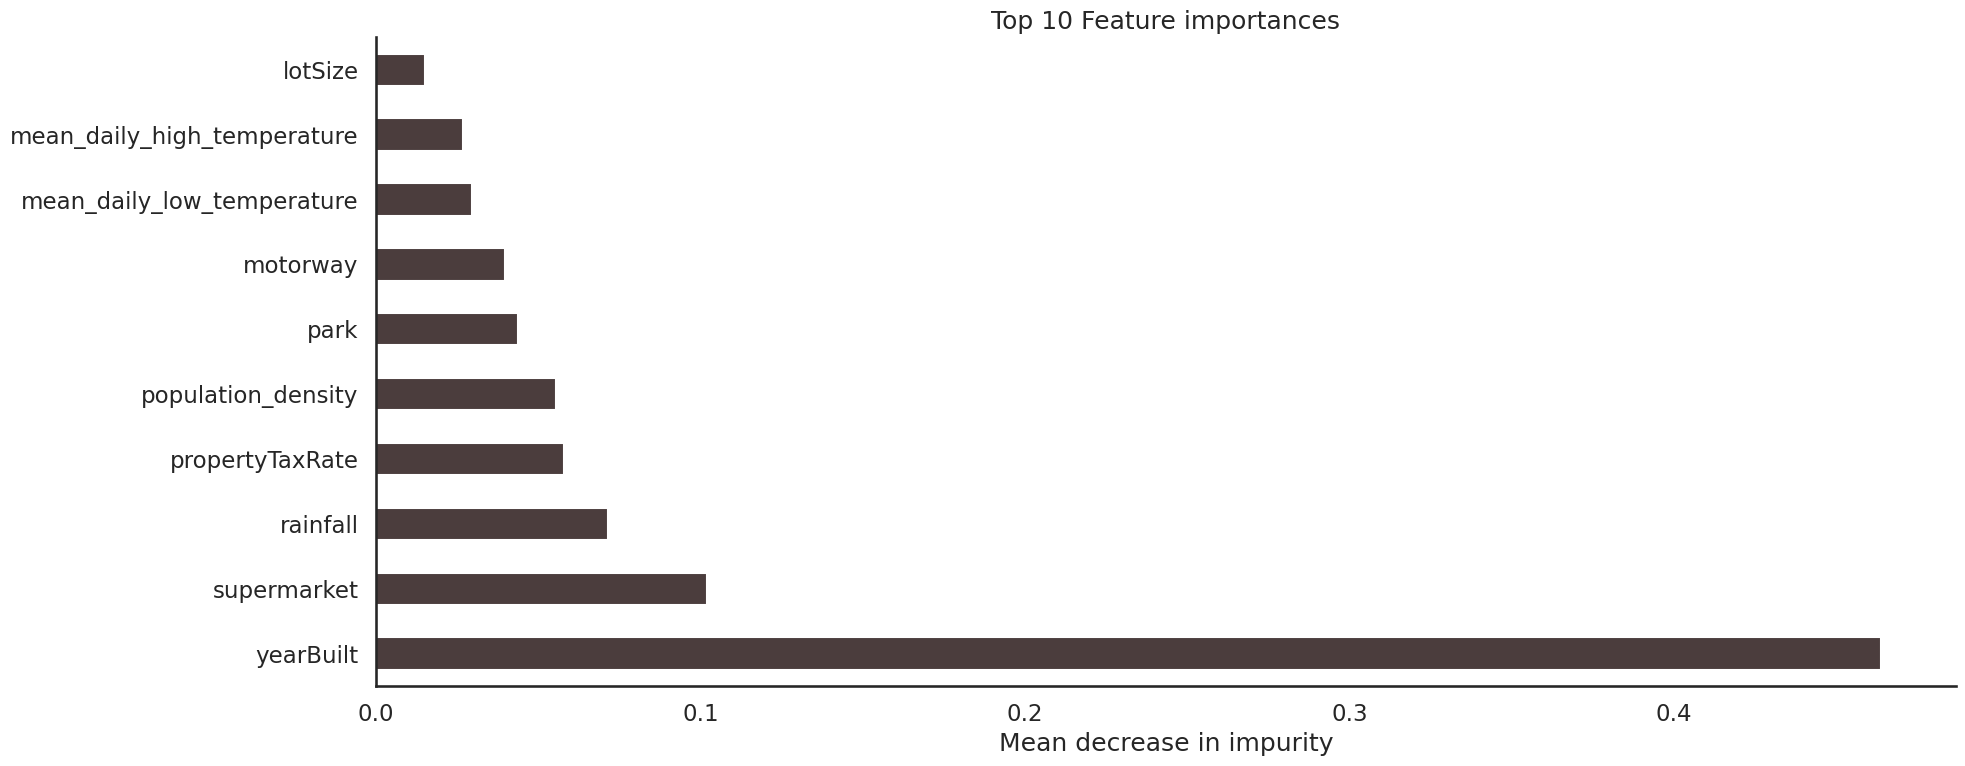

In [1919]:
t10_features = sorted(xgb_model.feature_importances_, reverse=True)[:10]
t10_features_names = sorted(xgb_model.feature_names_in_, reverse=True)[:10]
xgb_importances = pd.Series(t10_features, index=t10_features_names)

fig, ax = plt.subplots(figsize=(20,8))
xgb_importances.plot.barh(ax=ax)
ax.set_title("Top 10 Feature importances")
ax.set_xlabel("Mean decrease in impurity")
plt.tight_layout()
# plt.savefig(figure_path+"xgb_newdata_importance.png", dpi=300, transparent=True)
# files.download(figure_path+"xgb_newdata_importance.png")

Plot least important features

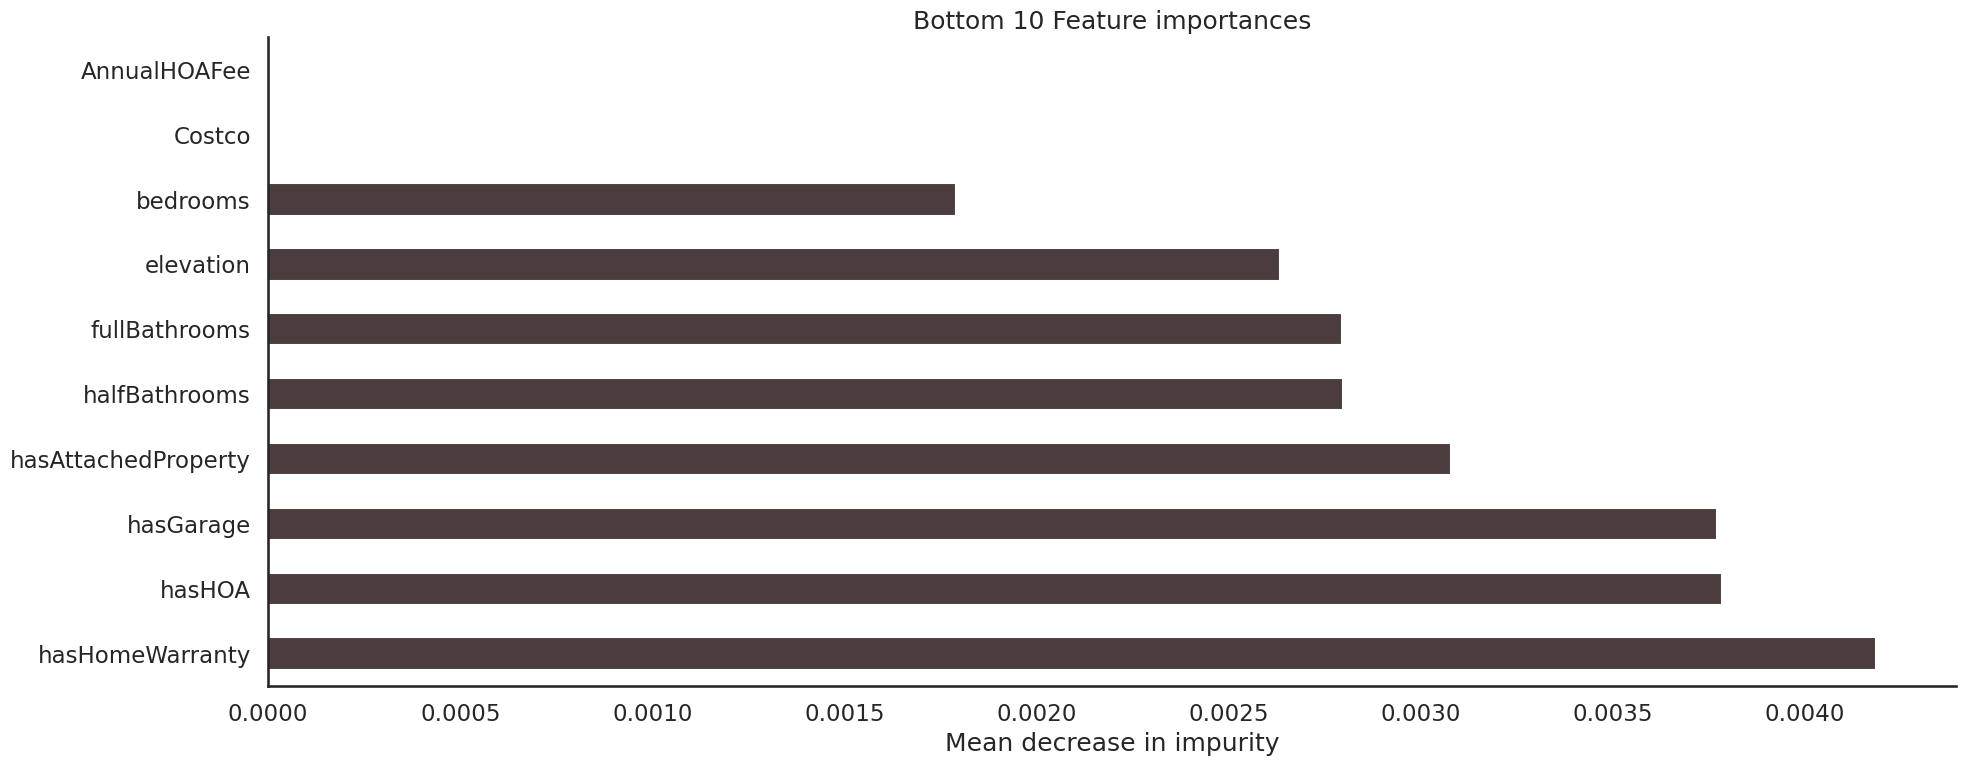

In [1920]:
l10_features = sorted(xgb_model.feature_importances_, reverse=True)[-10:]
l10_features_names = sorted(xgb_model.feature_names_in_, reverse=True)[-10:]
xgb_importances = pd.Series(l10_features, index=l10_features_names)

fig, ax = plt.subplots(figsize=(20,8))
xgb_importances.plot.barh(ax=ax)
ax.set_title("Bottom 10 Feature importances")
ax.set_xlabel("Mean decrease in impurity")
plt.tight_layout()
# plt.savefig(figure_path+"xgb_newdata_limportance.png", dpi=300, transparent=True)
# files.download(figure_path+"xgb_newdata_limportance.png")

Text(0, 0.5, 'features')

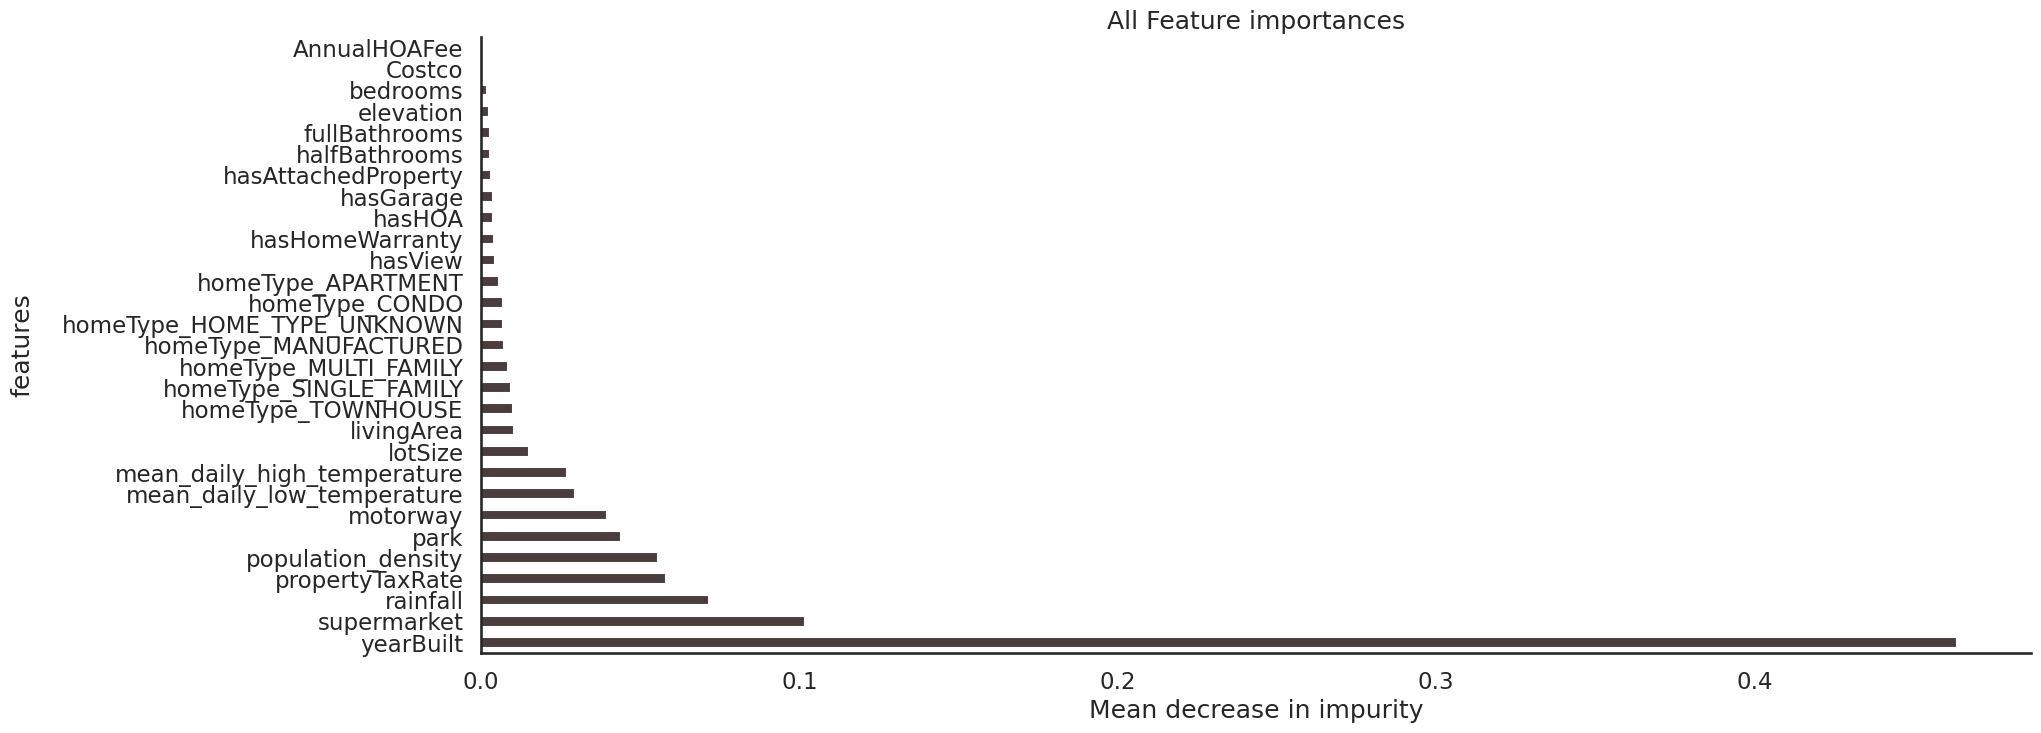

In [1921]:
all_features = sorted(xgb_model.feature_importances_, reverse=True)
all_features_names = sorted(xgb_model.feature_names_in_, reverse=True)
xgb_importances = pd.Series(all_features, index=all_features_names)

fig, ax = plt.subplots(figsize=(20,8))
xgb_importances.plot.barh(ax=ax)
ax.set_title("All Feature importances")
ax.set_xlabel("Mean decrease in impurity")
plt.ylabel("features", labelpad=20)
# plt.savefig(figure_path+"xgb_newdata_aimportance.png", dpi=300, transparent=True)

##### Visualize Shap

In [1922]:
# SHAP requires all values to be floats
X_train_float = X_train.select_dtypes(include=['int64', 'float64']).astype('float64')
X_test_float = X_test.select_dtypes(include=['int64', 'float64']).astype('float64')

In [1923]:
X_train_float.dtypes

lotSize                        float64
livingArea                     float64
AnnualHOAFee                   float64
fullBathrooms                  float64
halfBathrooms                  float64
bedrooms                       float64
propertyTaxRate                float64
yearBuilt                      float64
elevation                      float64
mean_daily_high_temperature    float64
mean_daily_low_temperature     float64
rainfall                       float64
population_density             float64
park                           float64
motorway                       float64
supermarket                    float64
Costco                         float64
dtype: object

In [1924]:
# Initialize the SHAP explainer
explainer = shap.TreeExplainer(xgb_model)

# Calculate SHAP values for the test data
shap_values = explainer.shap_values(X_test)

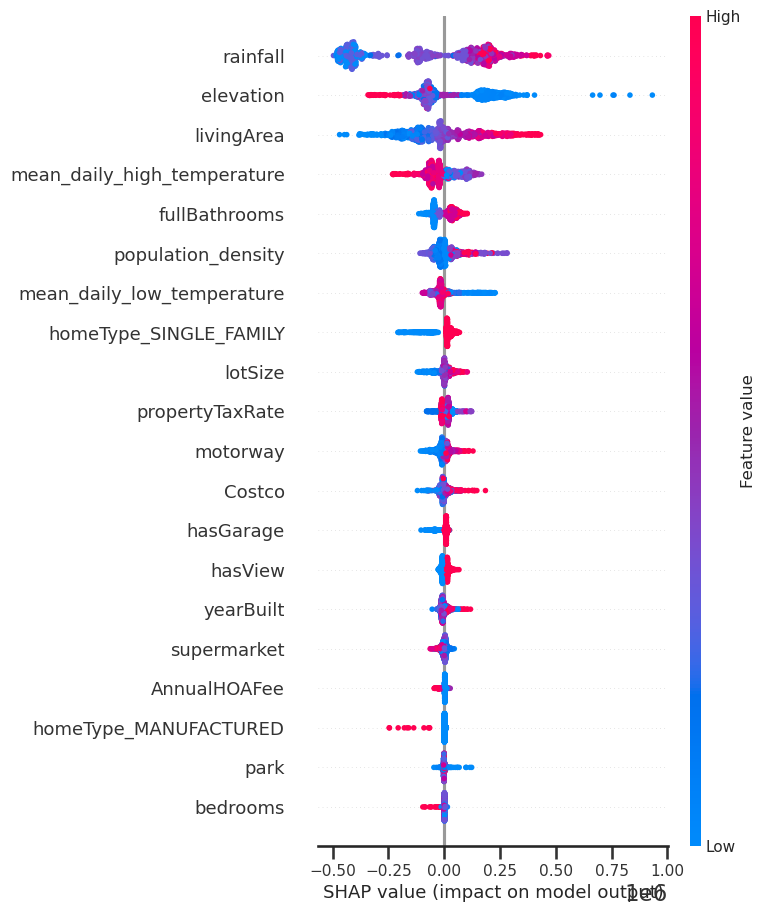

In [1925]:
# Plot SHAP summary plot to visualize feature importance
# Create figure with specific size
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test, show=False)
plt.tight_layout()
# plt.savefig('shap_summary_plot.png', dpi=300, transparent=True)
plt.show()
plt.close()
# files.download('shap_summary_plot.png')

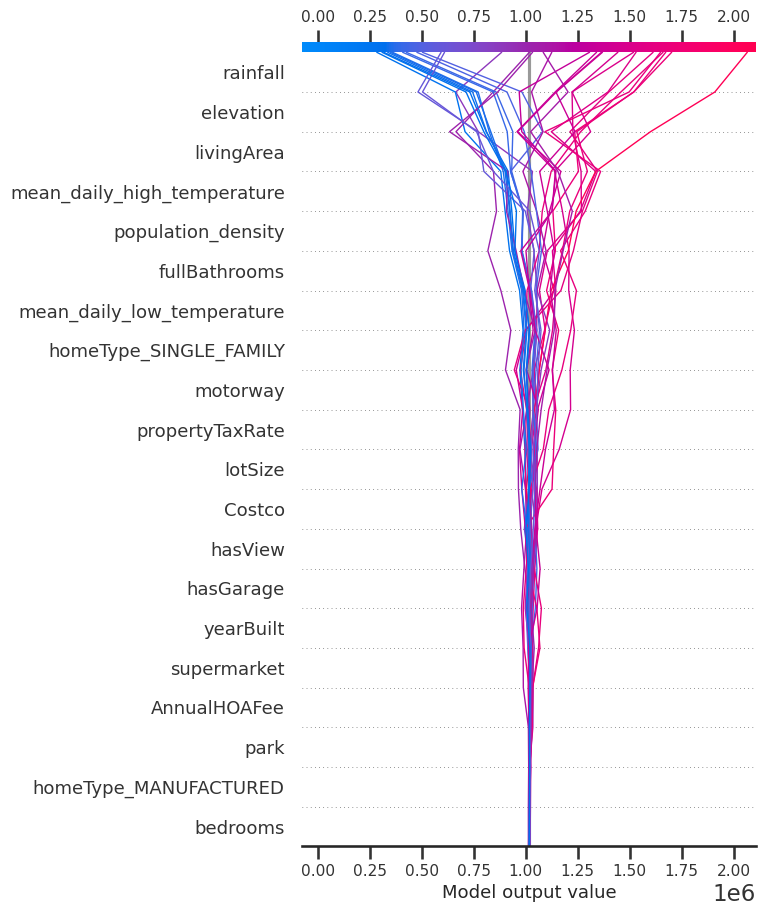

In [1926]:
plt.figure(figsize=(12, 8))
shap.decision_plot(explainer.expected_value, shap_values[0:30], X_test.values[0:30], feature_names=list(X_test.columns), show=False)
plt.tight_layout()
# plt.savefig('shap_decision_plot.png', transparent=True, bbox_inches='tight', dpi=300)
plt.show()
plt.close()
# files.download('shap_decision_plot.png')

#### XGBoost With PCA

In [1927]:
# Scale the data for PCA and model training
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [1928]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=0.95)  # Keep 95% of variance
X_pca_train = pca.fit_transform(X_train_scaled)
X_pca_test = pca.transform(X_test_scaled)

# Train XGBoost model on reduced dimensions
xgb_pca = xgb.XGBRegressor(n_estimators=1000, max_depth=5, min_child_weight=5, learning_rate=0.01, reg_alpha=0.1, reg_lambda=0.1)
xgb_pca.fit(X_pca_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [1929]:
# Evaluate using PCA on test data
print(f"Train R^2 (PCA): {xgb_pca.score(X_pca_train, y_train)}")
print(f"Test R^2 (PCA): {xgb_pca.score(X_pca_test, y_test)}")
print(f"Train RMSE (PCA): {root_mean_squared_error(y_train, xgb_pca.predict(X_pca_train))}")
print(f"Test RMSE (PCA): {root_mean_squared_error(y_test, xgb_pca.predict(X_pca_test))}")

Train R^2 (PCA): 0.9069908857345581
Test R^2 (PCA): 0.7884551286697388
Train RMSE (PCA): 179045.78279866176
Test RMSE (PCA): 270230.3265278449


Plot Residual Values

Text(0.5, 1.0, 'Predicted Values vs Residuals')

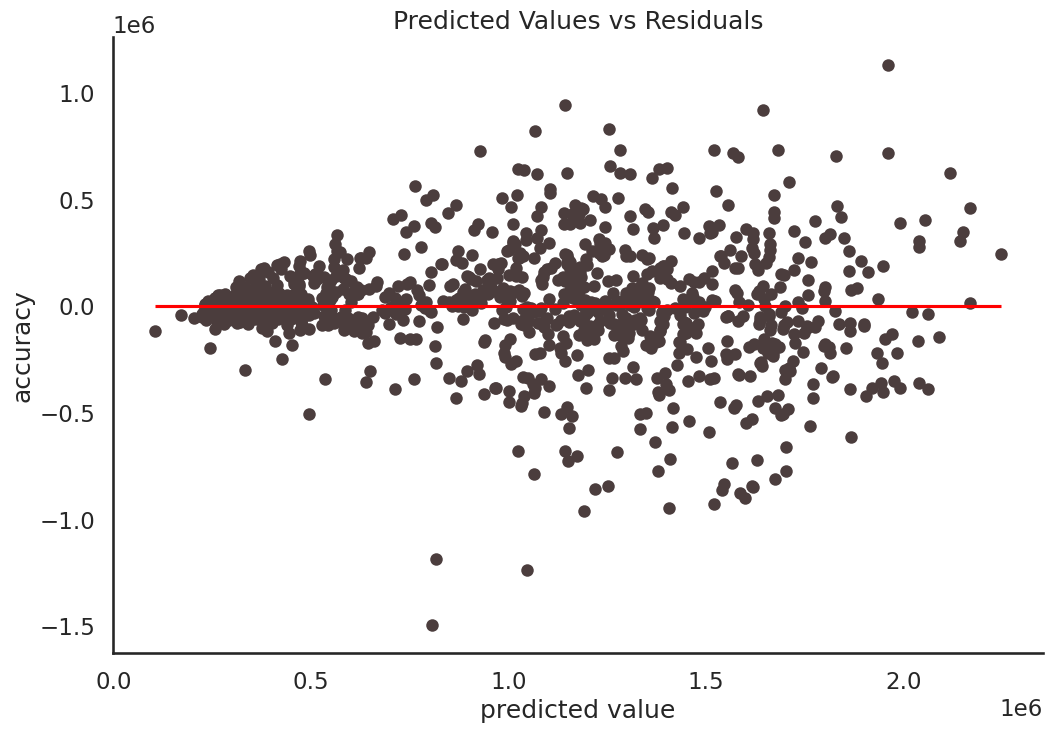

In [1930]:
pred = xgb_pca.predict(X_pca_test)
true = y_test
acc = pred - true
fig, ax = plt.subplots(figsize=(12,8))
sns.scatterplot(x=pred, y=acc, linewidth=0)
ax.hlines(y=0, xmin=pred.min(), xmax=pred.max(), colors='red')
plt.xlabel("predicted value")
plt.ylabel("accuracy")
plt.title("Predicted Values vs Residuals")
# plt.savefig(figure_path+"xgb3_residual.png", dpi=300, transparent=True)
# files.download(figure_path+"xgb3_residual.png")

Some assupmtions made:
- Houses in the same area have the same property tax rates
- lotSize includes livingArea
- Condos and Manufactured homes don't have lotSize outside of livingArea (lotSize == livingArea)